## Just run this stuff

### Imports, yes some are repeats

In [ ]:
import multiprocessing as mp, os
from functools import partial
mp.set_start_method("spawn", force=True)      # or "forkserver"
import psutil
import threading
import time
import functools
import math
# (optional) keep one BLAS thread per worker
os.environ["OMP_NUM_THREADS"]      = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"]      = "1"

from scipy.sparse import dia_array, csr_array, eye, diags as diags_array
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs, spsolve
from scipy.sparse import identity, csr_matrix
import time

import matplotlib.animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
#import optax
from copy import deepcopy
import datetime
import scipy.sparse as sps
#from interpax import interp2d
import pickle
from fractions import Fraction
from math import gcd,ceil
from functools import reduce
#import pygmo as pg
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import random as rnd

import numpy as np
import matplotlib.pyplot as plt
import os
#import optax
from copy import deepcopy
import datetime
import scipy.sparse as sps
from scipy import sparse
from matplotlib.patches import Rectangle, Circle


import pickle
try:
    os.chdir('/home/openam/Desktop/Nate/convexPreopt')
    #os.chdir('/home/hal90000/Desktop/Nate/2DSDPTMM')
    #os.chdir('/home/groundnet/Desktop/Nate/convexPreopt')
except:
    pass
#from microwaveTradLocalCore.sdpunited_microwavesdp2trad import *
from matplotlib.colors import ListedColormap
import time
import multiprocessing as mp
import subprocess
import scipy.io
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix, spmatrix
import sys

from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false



In [ ]:
def monitor_resources(log_list, stop_event, interval=0.5):
    parent = psutil.Process()
    while not stop_event.is_set():
        # Update the list of children each time to capture new subprocesses
        children = parent.children(recursive=True)
        all_procs = [parent] + children

        cpu = sum(p.cpu_percent(interval=None) for p in all_procs if p.is_running())
        mem = sum(p.memory_info().rss for p in all_procs if p.is_running())

        log_list.append((time.time(), cpu, mem))
        time.sleep(interval)


def log_resources_during(func=None, *, interval=0.5):
    def decorator(f):
        @functools.wraps(f)
        def wrapper(*args, **kwargs):
            log = []
            stop_event = threading.Event()
            monitor_thread = threading.Thread(target=monitor_resources, args=(log, stop_event, interval))
            monitor_thread.start()

            try:
                result = f(*args, **kwargs)
            finally:
                stop_event.set()
                monitor_thread.join()
            return result, log
        return wrapper

    # Allow both @decorator and @decorator(...)
    if func is not None:
        return decorator(func)
    return decorator

### Traditional Solvers (grad-free)

In [ ]:
def correllatedRandom(size,corrLen=2,minv=0,maxv=1,prngkey=0):
    x,y=np.arange(-corrLen,corrLen),np.arange(-corrLen,corrLen)
    X,Y=np.meshgrid(x,y)
    dist=np.sqrt(X**2+Y**2)
    filt=np.exp(-dist**2/(2*corrLen))
    rg=np.random.default_rng(prngkey)
    noise=rg.uniform(low=minv,high=maxv,size=size)
    return scipy.signal.convolve(noise,filt,mode='same')

class TimeBasedTerminationArchipelago:
    def __init__(self, archi, time_limit):
        """
        Wrapper to terminate the archipelago optimization based on time elapsed.
        :param archi: A pagmo archipelago instance.
        :param time_limit: Time limit in seconds.
        """
        self.archi = archi  # The archipelago
        self.time_limit = time_limit

    def evolve(self):
        """
        Evolve the archipelago with a time limit.
        """
        start_time = time.time()
        while True:
            self.archi.evolve(1)  # Evolve each island for one generation
            elapsed_time = time.time() - start_time
            if elapsed_time >= self.time_limit:
                print(f"Terminating optimization: Time limit of {self.time_limit}s reached.")
                break
        self.archi.wait_check()  # Ensure all islands finish

class fdfdProblem:
    def __init__(self,fdfdSimObject,allInt=True):
        self.fso=fdfdSimObject
        self.dim=fdfdSimObject.designRegionX*fdfdSimObject.designRegionY
        self.allInt=allInt
        return

    def fitness(self,dv):
        structureMat=np.reshape(np.where(dv<0.5,0,1),(self.fso.designRegionX,self.fso.designRegionY))
        sO,auxData=self.fso.getSO(structureMat)
        return [sO]

    def get_bounds(self):
        return ([0,]*self.dim,[1,]*self.dim)

    def get_nix(self):
        return self.dim*int(self.allInt)

class micropatchProblem:
    def __init__(self,micropatchSimObject,allInt=True):
        self.mso=micropatchSimObject
        self.size=(self.mso.size[0]//(1+int(self.mso.symmetryAxis=='y'))+int(self.mso.symmetryAxis=='y')),(micropatchSimObject.size[1]//(1+int(self.mso.symmetryAxis=='x'))+int(self.mso.symmetryAxis=='x'))
        self.dim=(micropatchSimObject.size[0]//(1+int(self.mso.symmetryAxis=='y'))+int(self.mso.symmetryAxis=='y'))*(micropatchSimObject.size[1]//(1+int(self.mso.symmetryAxis=='x'))+int(self.mso.symmetryAxis=='x'))
        self.allInt=allInt
        return

    def fitness(self,dv):
        structureMat=np.reshape(np.where(dv<0.5,0,1),self.size)
        sO,auxData=self.mso.getSO(structureMat)
        return [sO]

    def get_bounds(self):
        return ([0,]*self.dim,[1,]*self.dim)

    def get_nix(self):
        return self.dim*int(self.allInt)

def flipper(struc, flipProbs):
    """
    Flips each element of the binary array 'struc' with probability 'flipProbs'.
    Both 'struc' and 'flipProbs' must have the same shape.

    Parameters
    ----------
    struc : np.ndarray
        A binary NumPy array (elements are 0 or 1).
    flipProbs : np.ndarray
        A NumPy array of floats in [0,1], same shape as 'struc'.

    Returns
    -------
    np.ndarray
        The modified 'struc' array (same object, flipped in-place).
    """
    # Generate random numbers in [0,1] of the same shape

    rand_vals = np.random.rand(*struc.shape)
    #flipVals=np.random.randint(0,2,struc.shape)
    # Create a mask where flips occur
    #flip_mask = rand_vals < flipProbs
    # Flip from 0->1 or 1->0
    #struc[flip_mask] = flipVals[flip_mask]
    strucFinal=rand_vals < flipProbs
    return strucFinal

def mwSDP2mwTrad(resDict,useIt,archi,bias=1,debug=False):
    """
    Maps the results of an SDP run to a pygmo archipelago for further optimization. High ambiguity points will have higher probability of being ELIGIBLE for a flip; if eligible, they have a 50-50 chance of being set to 1 or 0.

    Arguments:
    resDict: a Result object, with data already loaded.
    useIt: tuple. The [gamma index, inner index] to use
    archi: pygmo archipelago, with problem, algorithm, and population size already set
    bias: scalar. A value less than 1 regresses all shuffle probabilioties towards a mean of 0.5 for everyone. A value greater than 1 makes high ambiguity points more liekly to flip, and low ambiguity points less likely.
    debug: bool. If True, will return shuffleProb in addition to the repopulated archipelago

    Returns:
    archi: same object as archi input, with population repalced by variations on the SDP result.
    """
    n=len(archi)
    RUC=resDict.__dict__['residUnchosen'][useIt[0]][useIt[1]]
    RC=resDict.__dict__['residChosen'][useIt[0]][useIt[1]]
    RMetal=[]
    RAir=[]
    STRUC=resDict.__dict__['struc'][useIt[0]][useIt[1]]
    for v,ruc,rc in zip(np.ravel(STRUC),RUC,RC):
        if v==0:
            RAir.append(rc)
            RMetal.append(ruc)
        else:
            RAir.append(ruc)
            RMetal.append(rc)
    DR=np.log10(np.asarray(RAir)/np.asarray(RMetal))
    #DRmean=np.mean(DR)
    #DRstd=np.std(DR)
    #DRdistance=(DR-DRmean)/DRstd
    DRdistance=np.reshape(DR,STRUC.shape)
    shuffleProb=jax.nn.sigmoid(DRdistance*bias)#mapper(DRdistance)
    print(shuffleProb)
    for i,island in enumerate(archi):
        popBase = island.get_population()        # get the population
        prob = popBase.problem
        #   Create an empty population for island i
        pop = pg.population(prob, size=0)

        # Every island will have the SDP structure in it as well
        pop.push_back(np.ravel(deepcopy(STRUC)))

        # Add each solution vector from initArrays[i]
        # (i.e., 120 vectors of the correct dimension).
        for j in range(len(popBase)-1):
            # vec should be something like [0, 1, 1, 0, ...]
            # that matches the problem dimension
            pop.push_back(np.ravel(flipper(deepcopy(STRUC),shuffleProb)))

        # Set this custom population into island i
        island.set_population(pop)
    if debug:
        return archi,shuffleProb
    else:
        return archi

def boundary_search(init, objectiveFunc, maxIterations, maxTime, staticNodes,
                    improveFactor=1.05, decayFactor=0.95):
    """
    Perform a boundary search on a binary (0/1) array to minimize objectiveFunc,
    using an adaptive probability distribution over boundary nodes.

    Parameters
    ----------
    init : numpy.ndarray
        Initial 2D array of shape (N, M) with 0/1 entries.
    objectiveFunc : callable
        A function that accepts a 2D numpy array (same shape as init)
        of 0/1 values and returns a float (the objective to minimize).
    maxIterations : int
        Maximum number of objective function evaluations.
    maxTime : float
        Maximum total runtime (seconds) before termination.
    staticNodes : numpy.ndarray
        A 2D array of shape (N, M) with 0/1 entries.
        If staticNodes[i, j] == 1, then the value at [i, j] in any candidate
        structure must remain as init[i, j] (i.e., cannot be flipped).
    improveFactor : float
        Factor by which to multiply the weights of flipped nodes
        when a flip leads to an improvement.
    decayFactor : float
        Factor by which to multiply the weights of flipped nodes
        when a flip does not lead to an improvement.

    Returns
    -------
    numpy.ndarray
        The best 2D array of 0/1 found (of shape (N, M)).
    """

    # Fixed seed for reproducibility
    np.random.seed(0)

    # Copy the initial structure
    best_structure = init.copy()
    # Evaluate objective at the initial structure
    best_value = objectiveFunc(best_structure)
    LV,Svals=mso.getSO(best_structure)
    # Keep track of how many times we've called objectiveFunc
    calls = 1

    # Time tracking
    start_time = time.time()
    '''
    fig,ax=plt.subplots(1,1,figsize=(3,3))
    ax.imshow(best_structure,cmap='Greys')
    ax.set_title('Loss: '+str(best_value)+'\nS: '+str(list(np.round(Svals,5)))+'\nIteration '+str(0))
    plt.show()
    '''
    # Create a weight matrix for all nodes:
    # - If a node is not flippable (staticNodes[i,j] == 1), set weight to 0.
    # - Otherwise, initialize to 1.
    W = np.ones_like(init, dtype=float)
    W[staticNodes == 1] = 0.0  # Not allowed to flip these => weight = 0
    bestStructures=[init.copy(),]
    performances=[(best_value,Svals),]
    # Main search loop
    while calls < maxIterations:
        # Check time limit
        if (time.time() - start_time) > maxTime:
            break

        # -----------------------------------------------------
        # 1) Identify boundary nodes (vectorized)
        # -----------------------------------------------------
        # Create a mask (same shape) for boundary cells
        boundary_mask = np.zeros_like(best_structure, dtype=bool)

        # Compare adjacent rows (vertical neighbors)
        diff_rows = best_structure[1:, :] != best_structure[:-1, :]
        boundary_mask[1:, :] |= diff_rows
        boundary_mask[:-1, :] |= diff_rows

        # Compare adjacent columns (horizontal neighbors)
        diff_cols = best_structure[:, 1:] != best_structure[:, :-1]
        boundary_mask[:, 1:] |= diff_cols
        boundary_mask[:, :-1] |= diff_cols

        # Must also be allowed to flip
        boundary_mask &= (staticNodes == 0)

        # Get list of boundary node indices
        boundary_idx = np.argwhere(boundary_mask)  # shape: (K, 2)

        if boundary_idx.size == 0:
            # No boundary nodes to flip => cannot improve further by boundary flips
            break

        # -----------------------------------------------------
        # 2) Randomly pick a non-empty subset of boundary nodes,
        #    but use an adaptive distribution over boundary nodes.
        # -----------------------------------------------------
        num_boundary = len(boundary_idx)
        # Randomly pick how many boundary nodes we'll flip
        subset_size = np.random.randint(1, 2 + 1)

        # Extract the weights for just the boundary nodes
        boundary_weights = W[boundary_idx[:, 0], boundary_idx[:, 1]]
        sum_bw = boundary_weights.sum()

        if sum_bw == 0:
            # If all weights are zero, fall back to uniform
            chosen = np.random.choice(num_boundary, size=subset_size, replace=False)
        else:
            # Probability distribution over boundary nodes
            p = boundary_weights / sum_bw
            chosen = np.random.choice(num_boundary, size=subset_size, replace=False, p=p)

        # -----------------------------------------------------
        # 3) Create a new candidate by flipping the chosen set
        # -----------------------------------------------------
        candidate = best_structure.copy()
        flip_coords = boundary_idx[chosen]  # shape: (subset_size, 2)
        candidate[flip_coords[:, 0], flip_coords[:, 1]] = 1 - candidate[flip_coords[:, 0],
                                                                        flip_coords[:, 1]]

        # Evaluate objective
        candidate_value = objectiveFunc(candidate)
        calls += 1
        # -----------------------------------------------------
        # 4) Check for improvement and update weights
        # -----------------------------------------------------
        if candidate_value < best_value:
            # Improvement
            best_value = candidate_value
            best_structure = candidate
            bestStructures.append(best_structure.copy())
            # Increase weights of flipped nodes
            W[flip_coords[:, 0], flip_coords[:, 1]] *= improveFactor
            LV,Svals=mso.getSO(candidate)
            performances.append((candidate_value,Svals))
            '''
            fig,ax=plt.subplots(1,1,figsize=(3,3))
            ax.imshow(candidate,cmap='Greys')

            ax.set_title('Loss: '+str(candidate_value)+'\nS: '+str(list(np.round(np.abs(Svals)**2,5)))+'\nIteration '+str(calls))
            plt.show()
            '''

        else:
            # Not an improvement => decrease weights
            W[flip_coords[:, 0], flip_coords[:, 1]] *= decayFactor

        # Termination check
        if calls >= maxIterations:
            break

    return bestStructures,performances


In [ ]:
np.mean(correllatedRandom((10,10),minv=0,maxv=0.175))

0.6479271602044934

### Simulators

#### MicropatchSim

In [ ]:
#@title MicropatchSim
class micropatchSim:
    def __init__(self):
        """
        Simulates a 2D array of 4-port lumped elements with known S-matrices

        Indexing is a tad complex. For a 2x2 array, for example, we have:
                    y=            0         1                2              3         4
             x=                             |                               |
               0             e[0]=a_{0,1} v |                e[2]=a_{0,3} v |
                             ^ e[1]=b_{0,1} |                ^ e[3]=b_{0,3} |
                                            |                               |
                          e[4]=a_{1,0} >    |        e[6]=a_{1,2} >         |    e[8]=a_{1,4} >
               1       ------------------S_{1,1}-------------------------S_{1,3}----------------
                          < e[5]=b_{1,0}    |        < e[7]=b_{1,2}         |    < e[9]=b_{1,4}
                                            |                               |
               2            e[10]=a_{2,1} v |               e[12]=a_{2,3} v |
                            ^ e[11]=b_{2,1} |               ^ e[13]=b_{2,3} |
                                            |                               |
                         e[14]=a_{3,0} >    |       e[16]=a_{3,2} >         |   e[18]=a_{3,4} >
               3       ------------------S_{3,1}-------------------------S_{3,3}----------------
                         < e[15]=b_{3,0}    |       < e[17]=b_{3,2}         |   < e[19]=b_{3,4}
               4                            |                               |
                            e[20]=a_{4,1} v |               e[22]=a_{4,3} v |
                            ^ e[21]=b_{4,1} |               ^ e[23]=b_{4,3} |
                                            |                               |

        Attributes:
            e: Dict. e[freq][i] is the ith field at frequency freq. Fields are indexed sequenctially by x-coordinate, then by y-coordinate.
        """
        self.sMats={}
        self.tMats={}
        self.freqs=[]
        self.e={}
        self.weights={}
        self.setName=0
        self.nodeMap=[]
        self.ni=1
        self.augBoundary=False
        self.plotSize=None
        self.useSparse=True
        return

    def load_sMatrix(self,path,setName=None,symmetrize=False):
        """
        Loads the S-matrix located in a touchstone file at path. Assumes 4x4, arbitrary number of frequencies, 8 header lines.
        S_matrix convention is         Port 1
                                        | |                     a is always right and down, b is always left and up
                               Port 3 ¯¯   ¯¯ Port 2            S.<a1,b2,a3,b4>=<b1,a2,b3,a4> -> T.<a1,b1,a3,b3>=<a4,b4,a2,b2>
                                      ¯¯| |¯¯
                                       Port 4
        Arguments:
        path: String. Path to the touchstone file. Include directory and extension
        setName: Int. The index of this set of matrices. If None, will be assigned the next integer.
        symmetrize: Bool. If True, will symmetrize the S-matrix assuming four-fold symmetry, so only three independent elements which will be computed via averaging
        """
        if setName is None: #Generate a set name if none was provided
            setName=deepcopy(self.setName)
            self.setName+=1
        self.sMats[setName],self.tMats[setName]={},{}
        f=open(path,'r')
        v=f.readline()
        while True: #Get rid of the header lines
            vs=v.split()
            try:
                float(vs[0])
                break
            except:
                v=f.readline()

        matRow,cFreq=0,0
        while v!='': #Run through the actual matrices
            vs=v.split()
            if len(vs)==9: #Most lines have 8 numbers, real/im components of S_{i,0} through S_{i,4}. The first line has an additional number, that being the frequency of the S-matrix.
                cFreq=float(vs[0])
                self.sMats[setName][cFreq]=np.zeros((4,4),dtype=np.complex64)
                matRow=0
                vs.pop(0)
            self.sMats[setName][cFreq][matRow,:]=np.array([float(vs[0])+1j*float(vs[1]),float(vs[2])+1j*float(vs[3]),float(vs[4])+1j*float(vs[5]),float(vs[6])+1j*float(vs[7])])
            matRow+=1
            v=f.readline()
        f.close()
        for fr in self.sMats[setName].keys(): #Now we symmetrize if necessary, as well as compile the list of frequencies.
            sm=(self.sMats[setName][fr])
            sms=sm.shape[0]
            if symmetrize: #The S-matrix for a 4-port device with four-fold symmetry should be
                                        #[ a   b   b   c ]  Due to numerical dispersion, it will not actually be this.
                a=np.average([sm[i,i] for i in range(sms)])                                                                 #[ b   a   c   b ]  Average over like elements to make it fully symmetric.
                b=np.average([np.average([sm[i,j] for i in range(sms) if (i!=j and i!=(sms-1-j))]) for j in range(sms)])    #[ b   c   a   b ]
                c=np.average([sm[i,sms-1-i] for i in range(sms)])                                                           #[ c   b   b   a ]
                self.sMats[setName][fr]=np.ones_like(self.sMats[setName][fr])*b
                for i in range(sms):
                    self.sMats[setName][fr][i,i]=a
                    self.sMats[setName][fr][i,sms-1-i]=c
            self.freqs.append(fr)
        return

    def set_structure(self,xElements,yElements,setMap=None,symmetryAxis=None):
        """
        Sets the overall structure

        Arguments:
        xElements: Integer. Number of micropatches in the x-direction (row of matrix in python speak). If symmetry is not None, this should be the number of patches ON BOTH SIDEs
        yElements: Integer. Number of micropatches in the y-direction (column of matrix in python speak). If symmetry is not None, this should be the number of patches ON BOTH SIDEs
        setMap: Array-like. Which set of S/T-matrices to use at each node. setMap[i][j]=some Int, the index of one of the matrix sets
        symmetryAxis: String or None. If None, no symmetery. If 'x', the structure will be assumed symmetric along the central x-axis. If 'y', the structure will be assumed symmetric along the central y-axis.
        """
        self.symmetryAxis=symmetryAxis
        self.oddAxisX,self.oddAxisY=0,0
        if symmetryAxis=='x': #If we have symmetry along x (so bisects the y-axis)
            self.oddAxisX=int(yElements%2) #We have an odd axis if we have an odd number of elements in the y-direction, meaning it bisects one or more elements
            yElements=int(np.ceil(yElements/2)) #Remove the symmetrized elements from the simulation
        elif symmetryAxis=='y': #Dido for symmetry along y
            self.oddAxisY=int(xElements%2)
            xElements=int(np.ceil(xElements/2))
        self.xElements=xElements
        self.yElements=yElements
        self.Adim=self.xElements*self.yElements*2*2+self.xElements*2*(1-self.oddAxisX)+self.yElements*2*(1-self.oddAxisY) #Each node has its right and down branches, and the left and top boundaries have nodes as well. The left boundaries have no nodes if it is a y-direction odd axis, and the top boundaries have no nodes if it is an x-direction odd axis, since these bisect the waveguides/patches
        if setMap is None: #If the user has not specified a set of matrices, choose a random one and use it for all elements
            setKey=list(self.sMats.keys())[0]
            setMap=np.ones((xElements,yElements),dtype=int)*setKey
        self.setMap=setMap
        self.eX,self.eY=np.array(list(range(0,self.xElements*2+1,2))),np.array(list(range(0,self.yElements*2+1-self.oddAxisX,2))) #x,y for even columns (y even)
        self.oX,self.oY=np.array(list(range(1,self.xElements*2+1-self.oddAxisY,2))),np.array(list(range(1,self.yElements*2+1,2))) #x,y for odd columns (y odd)
        self._vector2arrayBuilder()
        return

    def set_boundary(self,boundaryMap):
        """
        Sets global boundary constraints.

        Arguments:
        boundaryMap: Dictionary. Each key is an (x,y) coordinate pair representing a boundary node. Each entry is either:
                     >a tuple ("input",v) where v is a scalar representing the complex amplitude of the wave incident on node (x,y)
                     >a tuple ("scatter",v) where v is a scalar representing the ratio of incident to transmitted wave; transmitted = v*incident
                     >a tuple ("connection",l,s) where l is a list of (x',y') tuples representing nodes connected to (x,y) and s is the scattering matrix among them (fields ordered in matrix as they appear in list, with key first. S-matrix maps in fields to out fields)
                     Any node not represented in the dictionary will be assumed open, such that transmitted = -incident (remember your phase shifts!)
                     Including nodes which are cut off by symmetry is optional, and will affect nothing. Nodes to the left of/below the line of symmetry take precedence.
        """
        baseScatter=1
        if self.augBoundary:
            airVals=self.sMats[0][self.freqs[0]]
            x,y,z=airVals[0,0],airVals[0,1],airVals[0,-1]
            baseScatter=(x-z)*(x**2-4*y**2+2*x*z+z**2)/(x**2-2*y**2+x*z)
            #baseScatter=(x**3+x**2*(z-2)-(z-1)*z**2+y**2*(2+4*z)-x*(-1+4*y**2+z+z**2))/(1+x**2-2*y**2+x*(z-2)-z)
        for k in boundaryMap.keys(): #Check for 'connection' type boundary conditions, and propagate them to all connected nodes
            if boundaryMap[k][0]=='connection':
                bcv=boundaryMap[k]
                for li in range(1,len(bcv[1])+1):
                    boundaryMap[bcv[1][li]]=("connection",[k,]+bcv[1],bcv[2][li])
                boundaryMap[k]=("connection",[k,]+bcv[1],bcv[2][0])
                #At this point, "connection" boudnaries have 1 entry per connected node, with entry[1] being the list of all connected nodes and entry[2] being the row of the S-matrix associated with that node.
        bMkeys=list(boundaryMap.keys())
        self.boundaryMap={}
        for y in self.oY: #Run through all odd ys (columns with top/bottom outputs)
            if (0,y) in bMkeys: #If the user has specified a boundary condition for the nodes along the bottom of the structure, use it. Otherwise, default to an open condition (scatter=1 means a=-b)
                self.boundaryMap[(0,y)]=boundaryMap[(0,y)]
            else:
                self.boundaryMap[(0,y)]=("scatter",baseScatter)
            if (2*self.xElements,y) in bMkeys: #Dido for the nodes along the top of the structure
                self.boundaryMap[(2*self.xElements,y)]=boundaryMap[(2*self.xElements,y)]
            else:
                if self.symmetryAxis=='y': #If the bisection passes between lumped elements, then we want a=b along these nodes, as the b comes from the a in the symmetric component.
                    if not bool(self.oddAxisY):
                        self.boundaryMap[(2*self.xElements,y)]=("scatter",-1)
                    else:
                        pass
                else:
                    self.boundaryMap[(2*self.xElements,y)]=("scatter",baseScatter)
        for x in self.oX: #Dido for the left/right sides of the structure
            if (x,0) in bMkeys:
                self.boundaryMap[(x,0)]=boundaryMap[(x,0)]
            else:
                self.boundaryMap[(x,0)]=("scatter",baseScatter)
            if (x,self.yElements*2) in bMkeys:
                self.boundaryMap[(x,self.yElements*2)]=boundaryMap[(x,self.yElements*2)]
            else:
                if self.symmetryAxis=='x':
                    if not bool(self.oddAxisX):
                        self.boundaryMap[(x,self.yElements*2)]=("scatter",-1)
                    else:
                        pass
                else:
                    self.boundaryMap[(x,self.yElements*2)]=("scatter",baseScatter)
        return

    def _vector2arrayBuilder(self):
        """
        Builds the vector to array map.

        v2a[floor(i/2)]=(x,y) location of element i in e.
        a2v[(x,y)]= index i of the a-field at location (x,y)
        """
        self.v2a,self.a2v={},{}
        self.v2aN,self.a2vN={},{}
        j=0
        for x in range(0,self.xElements*2+1-self.oddAxisY):
            for y in range((x+1)%2,self.yElements*2+1-self.oddAxisX,2):
                self.a2v[(x,y)]=j*2
                self.v2a[j]=(x,y)
                j+=1
        j=0
        for x in range(1,self.xElements*2+1-self.oddAxisY,2):
            for y in range(1,self.yElements*2+1-self.oddAxisX,2):
                self.a2vN[(x,y)]=j
                self.v2aN[j]=(x,y)
                j+=1
        return

    def _array2vector(self,coords):
        """
        Converts an (x,y) coordinate point into a vector index for the concatenated fields. Gives the position of the a-element
        """
        return int(np.ceil(coords[0]/2)*self.yElements+np.floor(coords[0]/2)*(self.yElements+1-self.oddAxisX)+np.ceil((coords[1]+1)/2)-1)*2

    def _vector2array(self,ind):
        """
        Converts a vector index for the concatenated fields into an (x,y) coordinate point.
        """
        eInd=int(np.floor(ind/2))
        return self.v2a[eInd]

    def _checkTup(self,field,fieldInd=0):
        """
        Checks if field is a tuple, and if it isn't, converts it to a coordinate pair.
        """
        if not hasattr(field,'__iter__'):
            field=self._vector2array(field//2)
            fieldInd=field%2
        return field,fieldInd


    def _boundaryField2Node(self,field):
        """
        Returns the node boardering a boundary field. Returns None if not a boundary field

        Arguments:
        field: Tuple or int. If tuple, the (x,y) coordinates of the field. If int, the vector index of the field.
        """
        field,_=self._checkTup(field)
        if field[0]==0:
            return (1,field[1])
        elif field[0]==2*self.xElements:
            return (2*self.xElements-1,field[1])
        elif field[1]==0:
            return (field[0],1)
        elif field[1]==2*self.yElements:
            return (field[0],2*self.yElements-1)
        else:
            return None

    def _ioc(self,node,field,fieldInd=0):
        """
        Tests if the field is going into or out of node. Returns True if in, False if out, None if not neighboring

        Arguments:
        node: Tuple. (x,y) coordinates of the node. Both x and y must be odd.
        field: Tuple or int. If tuple, the (x,y) coordinates of the field. If int, the vector index of the field.
        fieldInd: int. Only used if field is a tuple. 0 means the first field at (x,y) ('a') and 1 means the second ('b').
        """
        field,fieldInd=self._checkTup(field,fieldInd)
        if (node[1]==field[1]-1) ^ (node[0]==field[0]-1):
            return bool(fieldInd)
        elif (node[0]==field[0]+1) ^ (node[1]==field[1]+1):
            return not bool(fieldInd)
        else:
            return None


    def _processBoundary(self,bnd,field):
        """
        Processes a boundaryMap entry

        Arguments:
        bnd: Tuple. Entry of boundaryMap.
        field: Tuple. Key of boundaryMap.
        """
        node=self._boundaryField2Node(field)
        vi=self._array2vector(field)
        aIn=self._ioc(node,field,fieldInd=0)
        rv=np.zeros(self.Adim,dtype=np.complex64)
        if bnd[0]=='input':
            rv[vi:(vi+2)]+=np.array([1*int(aIn),1*int(not aIn)]) #Here, we set the coeff of the input wave to 1/desired input amplitude, so in the source vector we simply add a 1 for this row; (1/amp)*f=1 -> f=amp
            sourceV=bnd[1]
        elif bnd[0]=='scatter':
            rv[vi:(vi+2)]+=np.array((bnd[1]*int(aIn)-int(not aIn),bnd[1]*int(not aIn)-int(aIn)))
            sourceV=0
        elif bnd[0]=='connection':
            incidents=[self._array2vector(ff)+int(self._ioc(self._boundaryField2Node(ff),ff,fieldInd=1)) for ff in bnd[1]] #array2vector gives the coordinate of the a-field. ioc will return 0 if a is the input, and 1 if b is the input.
            output=vi+int(aIn) #The out field of this row is the out amplitude of the current field. If aIn is True, a is the input, and aIn is 1, so the output is b (1+vi)
            rv[incidents]=np.array(bnd[2])
            rv[output]=-1
            sourceV=0
        elif bnd[0]=='output':
            rv[vi:(vi+2)]+=np.array((int(aIn),int(not aIn)))
            sourceV=0
        return rv,sourceV

    def compile_structure_sparse(self, freq):
        """
        Builds the system matrix at a given frequency by assembling COO lists
        and converting to CSR, with explicit loops to ensure exact value placement.
        """
        # Choose the nearest frequency
        chosenFreqi = np.argmin(np.abs(np.array(self.freqs) - freq))
        chosenFreq  = self.freqs[chosenFreqi]

        # Prepare COO accumulation lists and RHS
        rows, cols, data = [], [], []
        self.J = np.zeros(self.Adim, dtype=np.complex128)

        k = 0

        # 1) Upper boundary rows
        for y in range(1, self.yElements*2+1-self.oddAxisX, 2):
            rv, src = self._processBoundary(self.boundaryMap[(0, y)], (0, y))
            nz = np.nonzero(rv)[0]
            for idx in nz:
                rows.append(k)
                cols.append(int(idx))
                data.append(rv[idx])
            self.J[k] = src
            self.nodeMap.append(0)
            k += 1

        # 2) Left boundary + interior
        for x in range(1, self.xElements*2+1-self.oddAxisY, 2):
            # Left boundary at (x,0)
            rv, src = self._processBoundary(self.boundaryMap[(x, 0)], (x, 0))
            nz = np.nonzero(rv)[0]
            for idx in nz:
                rows.append(k)
                cols.append(int(idx))
                data.append(rv[idx])
            self.J[k] = src
            self.nodeMap.append(0)
            k += 1

            # Interior 4-port nodes
            for y in range(0, (self.yElements-1)*2+1, 2):
                # Compute inlet/outlet indices
                vU = self._array2vector((x-1, y+1))
                vR = self._array2vector((x,   y+2))
                vL = self._array2vector((x,   y  ))
                vD = self._array2vector((x+1, y+1))
                ins  = [vU, vR+1, vL,   vD+1]
                outs = [vU+1, vR,   vL+1, vD  ]

                sMat = self.sMats[self.setMap[x//2, y//2]][chosenFreq]

                # X-axis symmetry: 3×3 reduced block
                if self.symmetryAxis=='x' and self.oddAxisX and y==(self.yElements-1)*2:
                    # Build 3×3 S
                    s3 = np.array([
                        (sMat[0,0], sMat[0,1]+sMat[0,2], sMat[0,3]),
                        (sMat[1,0], sMat[1,1]+sMat[1,2], sMat[1,3]),
                        (sMat[3,0], sMat[3,1]+sMat[3,2], sMat[3,3]),
                    ], dtype=np.complex128)
                    # Reduced connectivity
                    ins_x  = [ins[i] for i in (0,2,3)]
                    outs_x = [outs[i] for i in (0,2,3)]
                    # Assemble
                    for i in range(3):
                        for j in range(3):
                            rows.append(k + i)
                            cols.append(ins_x[j])
                            data.append(s3[i,j])
                        rows.append(k + i)
                        cols.append(outs_x[i])
                        data.append(-1.0+0j)
                    self.nodeMap += [self.ni] * 3
                    self.ni    += 1
                    k        += 3

                # Y-axis symmetry: 3×3 reduced block
                elif self.symmetryAxis=='y' and self.oddAxisY and x==(self.xElements*2-self.oddAxisY):
                    s3 = np.array([
                        (sMat[0,0]+sMat[0,3], sMat[0,1], sMat[0,2]),
                        (sMat[1,0]+sMat[1,3], sMat[1,1], sMat[1,2]),
                        (sMat[2,0]+sMat[2,3], sMat[2,1], sMat[2,2]),
                    ], dtype=np.complex128)
                    ins_y  = [ins[i] for i in (0,1,2)]
                    outs_y = [outs[i] for i in (0,1,2)]
                    for i in range(3):
                        for j in range(3):
                            rows.append(k + i)
                            cols.append(ins_y[j])
                            data.append(s3[i,j])
                        rows.append(k + i)
                        cols.append(outs_y[i])
                        data.append(-1.0+0j)
                    self.nodeMap += [self.ni] * 3
                    self.ni    += 1
                    k        += 3

                # Default: full 4×4 block
                else:
                    for i in range(4):
                        for j in range(4):
                            rows.append(k + i)
                            cols.append(ins[j])
                            data.append(sMat[i,j])
                        rows.append(k + i)
                        cols.append(outs[i])
                        data.append(-1.0+0j)
                    self.nodeMap += [self.ni] * 4
                    self.ni    += 1
                    k        += 4

            # Far-right boundary if not oddAxisX
            if not bool(self.oddAxisX):
                rv, src = self._processBoundary(
                    self.boundaryMap[(x, self.yElements*2)],
                    (x, self.yElements*2)
                )
                nz = np.nonzero(rv)[0]
                for idx in nz:
                    rows.append(k)
                    cols.append(int(idx))
                    data.append(rv[idx])
                self.J[k] = src
                self.nodeMap.append(0)
                k += 1

        # Bottom boundary if not oddAxisY
        if not bool(self.oddAxisY):
            for y in range(1, self.yElements*2+1-self.oddAxisX, 2):
                rv, src = self._processBoundary(
                    self.boundaryMap[(self.xElements*2, y)],
                    (self.xElements*2, y)
                )
                nz = np.nonzero(rv)[0]
                for idx in nz:
                    rows.append(k)
                    cols.append(int(idx))
                    data.append(rv[idx])
                self.J[k] = src
                self.nodeMap.append(0)
                k += 1

        A_coo = sps.coo_matrix((data, (rows, cols)),
                              shape=(self.Adim, self.Adim),
                              dtype=np.complex128)
        self.A = A_coo.tocsr()
        return

    def compile_structure(self,freq):
        """
        Builds the system matrix at a given frequency

        Arguments:
        freq: Float. Frequency of the selected S-matrix. The closest frequency to the entered one will be used.
        """
        chosenFreqi=np.argmin(np.abs(np.array(self.freqs)-freq)) #Find the closest frequency to the one requested
        chosenFreq=self.freqs[chosenFreqi]
        self.A=np.zeros((self.Adim,self.Adim),dtype=np.complex64)
        self.J=np.zeros(self.Adim,dtype=np.complex64)
        nI=-np.identity(4,dtype=np.complex64)
        nI3=-np.identity(3,dtype=np.complex64)
        k=0
        for y in range(1,self.yElements*2+1-self.oddAxisX,2): #Run through the upper boundaries
            #print('Processing boundary at '+str((0,y))+', with boundaryMap '+str(self.boundaryMap[(0,y)]))
            self.A[k,:],self.J[k]=self._processBoundary(self.boundaryMap[(0,y)],(0,y))
            self.nodeMap.append(0)
            k+=1
        for x in range(1,self.xElements*2+1-self.oddAxisY,2): #Run through all the odd x, which are in-line with the lumped elements (even x have no associated element)
            #print('Processing boundary at '+str((x,0))+', with boundaryMap '+str(self.boundaryMap[(x,0)]))
            self.A[k,:],self.J[k]=self._processBoundary(self.boundaryMap[(x,0)],(x,0)) #Process the leftmost boundary
            self.nodeMap.append(0)
            k+=1
            for y in range(0,(self.yElements-1)*2+1,2): #Run through all the y's
                vU,vR,vL,vD=self._array2vector((x-1,y+1)),self._array2vector((x,y+2)),self._array2vector((x,y)),self._array2vector((x+1,y+1)) #a-coordinates of field on top (Port 1), right (Port 2), left (Port 3), and bottom (Port 4) of the node (node is i=x, j=y+1)
                ins=[vU,vR+1,vL,vD+1]#The index of the fields going into the node
                outs=[vU+1,vR,vL+1,vD]#The index of the fields going out of the node
                #print('Processing interior at '+str((x,y))+' with in-indices '+str(ins)+' and out-indices '+str(outs)+' and node '+str([int(np.floor(x/2)),int(np.floor(y/2))])+'. x-bisection condition is y=='+str((((self.yElements-1)*2+1)-((self.yElements-1)*2+1)%2))+'. y-bisection condition is x=='+str((self.xElements*2+1-self.oddAxisY-2)+1))
                sMat=self.sMats[self.setMap[int(np.floor(x/2)),int(np.floor(y/2))]][chosenFreq] #Get the appropriate S-matrix
                if self.symmetryAxis=='x' and self.oddAxisX and y==((self.yElements-1)*2+1)-((self.yElements-1)*2+1)%2: #If we have x-direction symmetry and this element falls on an odd axis
                    sMat=np.array(((sMat[0,0],sMat[0,1]+sMat[0,2],sMat[0,3]),(sMat[1,0],sMat[1,1]+sMat[1,2],sMat[1,3]),(sMat[3,0],sMat[3,1]+sMat[3,2],sMat[3,3])))
                    ins.pop(1)                  #Then we reduce the matrix to [ a   2b   c ]
                    outs.pop(1)                 #                             [ b   a+c  b ]
                    self.A[k:(k+3),ins]+=sMat   #                             [ c   2b   a ]
                    self.A[k:(k+3),outs]+=nI3
                    self.nodeMap+=[self.ni,self.ni,self.ni]
                    self.ni+=1
                    k+=3
                    #print('Went to bisection along y, new in-indices are '+str(ins)+' and out-indices '+str(outs))
                elif self.symmetryAxis=='y' and self.oddAxisY and x==(self.xElements*2+1-self.oddAxisY-2)+1: #Dido for y-direction symmetry
                    sMat=np.array(((sMat[0,0]+sMat[0,3],sMat[0,1],sMat[0,2]),(sMat[1,0]+sMat[1,3],sMat[1,1],sMat[1,2]),(sMat[2,0]+sMat[2,3],sMat[2,1],sMat[2,2])))
                    ins.pop(-1)                  #Then we reduce the matrix to [ a+c  b  b ]
                    outs.pop(-1)                 #                             [ b+b  a  c ]
                    self.A[k:(k+3),ins]+=sMat    #                             [ b+b  c  a ]
                    self.A[k:(k+3),outs]+=nI3
                    self.nodeMap+=[self.ni,self.ni,self.ni]
                    self.ni+=1
                    k+=3
                    #print('Went to bisection along y, new in-indices are '+str(ins)+' and out-indices '+str(outs))
                else: #Otherwise, plug in the entire matrix
                    #print('Went to default operation, full S-matrix')
                    self.A[k:(k+4),ins]+=sMat
                    self.A[k:(k+4),outs]+=nI
                    self.nodeMap+=[self.ni,self.ni,self.ni,self.ni]
                    self.ni+=1
                    k+=4
            if not bool(int(self.oddAxisX)): #If we do not have an odd x-symmetric axis, do the far right boundary nodes
                #print('Processing boundary at '+str((x,self.yElements*2))+', with boundaryMap '+str(self.boundaryMap[(x,self.yElements*2)]))
                self.A[k,:],self.J[k]=self._processBoundary(self.boundaryMap[(x,self.yElements*2)],(x,self.yElements*2))
                self.nodeMap.append(0)
                k+=1
        if not bool(int(self.oddAxisY)): #If we do not have an odd y-symmetric axis, do the lower boundary nodes
            for y in range(1,self.yElements*2+1-self.oddAxisX,2):
                #print('Processing boundary at '+str((self.xElements*2,y))+', with boundaryMap '+str(self.boundaryMap[(self.xElements*2,y)]))
                self.A[k,:],self.J[k]=self._processBoundary(self.boundaryMap[(self.xElements*2,y)],(self.xElements*2,y))
                self.nodeMap.append(0)
                k+=1
        if self.useSparse:
            self.A=sps.csr_matrix(self.A)
        return

    @log_resources_during(interval=0.5)
    def solve_system(self,freqs=[1.0]):
        """
        Runs a frequency sweep

        Arguments:
        freqs: List. List of frequencies to sweep. Each set of matrices represented in setMap should have a matrix at the given frequency.
        """
        if not hasattr(freqs,'__iter__'):
            freqs=[freqs]
        self.ts=[]
        for ff in freqs:
            t0=time.perf_counter()
            if not self.useSparse:
                self.compile_structure(ff)
                self.e[ff]=np.linalg.solve(self.A,self.J)

            else:
                self.compile_structure_sparse(ff)
                self.e[ff]=sps.linalg.spsolve(self.A,self.J,use_umfpack=True)
            self.ts.append(time.perf_counter()-t0)
        return

    def graph_system(self):
        """
        Converts the simulation results to a networkx graph for visualization/analysis. Access the graphs (one per frequency) as elements of the dictionary self.Gs.
        """
        self.Gs={}
        for ff in self.e.keys():
            self.Gs[ff]=nx.DiGraph()
            self.pos={}
            self.labelDict={}
            for i in sorted(list(self.v2aN.keys())):
                self.Gs[ff].add_node(i,label=self.v2aN[i])
                self.labelDict[i]=self.v2aN[i]
                self.pos[i]=self.v2aN[i]
            i+=1
            v2aN=deepcopy(self.v2aN)
            a2vN=deepcopy(self.a2vN)
            for bN in self.boundaryMap.keys():
                if bN[0]==0:
                    nodeLoc=(-1,bN[1])
                elif bN[0]==2*self.xElements:
                    nodeLoc=(2*self.xElements+1,bN[1])
                elif bN[1]==0:
                    nodeLoc=(bN[0],-1)
                elif bN[1]==2*self.yElements:
                    nodeLoc=(bN[0],2*self.yElements+1)
                self.Gs[ff].add_node(i,label=nodeLoc)
                self.labelDict[i]=nodeLoc
                v2aN[i]=nodeLoc
                a2vN[nodeLoc]=i
                self.pos[i]=nodeLoc
                i+=1
            for ind in range(0,len(self.e[ff]),2):
                fieldCoord=self.v2a[ind//2]
                sourceNodeCoord=(fieldCoord[0]-(fieldCoord[0]+1)%2,fieldCoord[1]-(fieldCoord[1]+1)%2)
                sourceNode=a2vN[sourceNodeCoord]
                targetNodeCoord=(fieldCoord[0]+(fieldCoord[0]+1)%2,fieldCoord[1]+(fieldCoord[1]+1)%2)
                targetNode=a2vN[targetNodeCoord]
                self.Gs[ff].add_edge(sourceNode,targetNode,weight=self.e[ff][ind])
                self.Gs[ff].add_edge(targetNode,sourceNode,weight=self.e[ff][ind+1])
        return

    def plot_system(self,freq):
        """
        Plots the graphed simulation results at frequency freq
        """
        options = {
            "font_size": 6,
            "node_size": 250,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }
        posInv={}
        maxx=np.max([v[0] for _,v in self.pos.items()])
        for k,v in self.pos.items():
            posInv[k]=(v[1],maxx-v[0])
        #nx.draw_networkx(self.G, self.pos, arrowstyle='-|>', arrowsize=np.abs(np.array(self.weights)), connectionstyle='arc3,rad=0.2', **options)
        nx.draw_networkx_nodes(self.Gs[freq], posInv, node_size=options["node_size"])

        # Draw the edges with width proportional to the edge weight
        for (u, v, d) in self.Gs[freq].edges(data=True):
            weight = np.abs(d['weight'])
            nx.draw_networkx_edges(
                self.Gs[freq], posInv, edgelist=[(u, v)],
                width=weight,  # Use edge weight for arrow width
                arrowstyle='-|>', arrowsize=15,
                connectionstyle='arc3,rad=0.2' if (u, v) != (v, u) else 'arc3,rad=-0.2'
            )

        # Draw the labels
        nx.draw_networkx_labels(self.Gs[freq], posInv, font_size=options["font_size"], font_family="sans-serif", labels=self.labelDict)
        ax = plt.gca()
        ax.margins(0.20)
        plt.axis("off")
        fig = matplotlib.pyplot.gcf()
        if self.plotSize is not None:
            fig.set_size_inches(self.plotSize[0],self.plotSize[1])
        plt.show()
        return

    def get_networkS(self):
        """
        Extracts the network S-parameters from the simulation results.
        """
        self.networkS={}
        for ff in self.e.keys():
            self.networkS[ff]={}
            ins,refs,outs,bndsIn,bndsOut=[],[],[],[],[]
            for bnd in self.boundaryMap.keys():
                bv=self.boundaryMap[bnd]
                if bv[0]=="input":
                    ins.append(bv[1])
                    node=self._boundaryField2Node(bnd)
                    aIn=self._ioc(node,bnd,fieldInd=0)
                    refs.append(self.e[ff][self.a2v[bnd]+int(aIn)])
                    bndsIn.append(bnd)
                elif bv[0]=="output":
                    node=self._boundaryField2Node(bnd)
                    aIn=self._ioc(node,bnd,fieldInd=0)
                    outs.append(self.e[ff][self.a2v[bnd]+int(aIn)])
                    bndsOut.append(bnd)
            for iM,rM,b in zip(ins,refs,bndsIn):
                self.networkS[ff][b]={b:rM/iM}
                for oM,bo in zip(outs,bndsOut):
                    self.networkS[ff][b][bo]=oM/iM
            if self.symmetryAxis=='x':
                for source in self.networkS[ff].keys():
                    targets=tuple(self.networkS[ff][source].keys())
                    for target in targets:
                        if (target[0]!=0 or target[1]!=self.yElements*2-1) and (target[0]!=self.eX[-1] or target[1]!=self.yElements*2-1):
                            self.networkS[ff][source][(target[0],self.yElements*4-2-target[1])]=self.networkS[ff][source][target]
            if self.symmetryAxis=='y':
                for source in self.networkS[ff].keys():
                    targets=tuple(self.networkS[ff][source].keys())
                    for target in targets:
                        if (target[1]!=0 or target[0]!=self.xElements*2-1) and (target[1]!=self.eY[-1] or target[0]!=self.xElements*2-1):
                            self.networkS[ff][source][(self.xElements*4-2-target[0],target[1])]=self.networkS[ff][source][target]
        return self.networkS

    def get_outputPure(self):
        """
        Extracts the network S-parameters from the simulation results.
        """
        outputVals=[]
        for ff in self.e.keys():
            outputVals.append({})
            for bnd in self.boundaryMap.keys():
                bv=self.boundaryMap[bnd]
                if bv[0]=="output":
                    node=self._boundaryField2Node(bnd)
                    aIn=self._ioc(node,bnd,fieldInd=0)
                    outputVals[-1][bnd]=self.e[ff][self.a2v[bnd]+int(aIn)]
        return outputVals

    def extractFieldsAt(self,freq,coords):
        """

        """
        fieldInd=self.a2v[coords]
        return self.e[ff][fieldInd:(fieldInd+2)]

    def plotSpectrum(self,nodeSet=[],tp='real',figsize=(6,6)):
        """
        Plots s-param spectrum.

        Arguments:
        nodeSet: List. List of in/out nodes to plot. Each element is a two-tuple ((x_in,y_in),(x_out,y_out))
        tp: String. Type of plot. 'real', 'imag', 'mag', 'phase', 'magdB'
        """
        processDict={'real':np.real,'imag':np.imag,'mag':np.abs,'phase':np.angle,'magdb':lambda x: 10*np.log10(np.abs(x)**2)}
        xs,ys,labels=[],[],[]
        for ns in nodeSet:
            xs.append([])
            ys.append([])
            labels.append(ns)
            n1,n2=ns
            for ff in self.networkS:
                ys[-1].append(processDict[tp.lower()](self.networkS[ff][n1][n2]))
                xs[-1].append(ff)
        fig,ax=plt.subplots(1,1,figsize=figsize)
        for x,y,l in zip(xs,ys,labels):
            ax.plot(x,y,label=str(l))
        ax.legend()
        ax.set_xlabel('Frequency')
        ax.set_ylabel("S-param ("+tp+")")
        plt.show()
        return

In [ ]:
#@title micropatchSimObject
class micropatchSimObject(micropatchSim):
    def __init__(self):
        micropatchSim.__init__(self)
        self.augBoundary=True
        self.timings=[]
        return

    def add_ports(self,portLocations,portTypes,portParams,freq):
        '''
        portParams[f][0][i]= Target magnitude of S=|a|^2 at frequency f for port i.
        portParams[f][1][i]= Target phase in degrees of S=|a|e^{i*phase/180*pi} at frequency f for port i.
        portParams[f][2][i]= Weight on magntiude objective at frequency f for port i.
        portParams[f][3][i]= Weight on phase objective at frequency f for port i.
        portParams[f][4][i]= Equiphase target port at frequency f
        portParams[f][5][i]= Weight on equiphase objective at frequency f for port i.
        portParams[f][6][i]= EquiMag target port at frequency f
        portParams[f][7][i]= Weight on equiMag objective at frequency f for port i.
        portParams[f][8][i]= Weight on squared mag in port i at frequency f
        portParams[f][9][i]= Weight on inverse squared mag in port i at frequency f
        '''
        self.portLocations=portLocations
        self.portTypes=portTypes
        self.portParams=portParams
        self.portInfo={'portParams':[],'portLocations':[],'portTypes':[]}
        self.portInfo['portParams'].append(self.portParams)
        self.portInfo['portLocations'].append(self.portLocations)
        self.portInfo['portTypes'].append(self.portTypes)
        self.boundaryMap={}
        self.inPLs=[]
        self.outPLs=[]
        for pl,pt in zip(portLocations,portTypes):
            if pt=='input':
                self.boundaryMap[pl]=(pt,1)
                self.inPLs.append(pl)
            else:
                self.boundaryMap[pl]=(pt,)
                self.outPLs.append(pl)
        if not hasattr(freq,'__iter__'):
            freq=[freq,]
        self.ufreqs=freq
        return

    def add_sMats(self,files):
        if not hasattr(files,'__iter__'):
            files=[files,]
        for file in files:
            self.load_sMatrix(file)
        return

    def add_structure(self,setMap,symmetryAxis=None):
        '''
        Defines structure of the SDP problem. setMap should have a value of -1 for designable points, and the set number index elsewhere. Designable points will choose between set 0 and set 1.
        '''
        self.size=setMap.shape

        self.usetMap=setMap
        self.symmetryAxis=symmetryAxis
        self.set_structure(self.size[0],self.size[1],setMap,symmetryAxis=symmetryAxis)
        self.structSize=(self.xElements,self.yElements)
        return

    def compileSDP(self):
        self.auxFields=[]
        self.sizeOneFreq=(self.xElements*self.yElements*2+self.xElements*int(self.symmetryAxis!='x')+self.yElements*int(self.symmetryAxis!='y'))*2*2
        for j,f in enumerate(self.ufreqs):
            for i,pl in enumerate(self.portLocations):
                locR,locI=self.findPortOutIndex(pl,j)
                self.auxFields+=[locR,locI]*int(self.portParams[j][2,i]!=0)
                #if len(self.portParams[j])>4 and self.portParams[j][5,i]!=0:
                #    target=int(self.portParams[j][4,i])
                #    locRTarget,locITarget=self.findPortOutIndex(self.portLocations[target],j)
                #    self.auxFields+=[[locR,locITarget],[locI,locRTarget]]
        grandASize=[self.sizeOneFreq*len(self.ufreqs),self.sizeOneFreq*len(self.ufreqs)]
        self.grandAUp=np.zeros(grandASize)
        setMapUp=np.where(self.usetMap<0,1,self.usetMap)
        self.set_structure(self.size[0],self.size[1],setMap=setMapUp,symmetryAxis=self.symmetryAxis)
        self.set_boundary(boundaryMap=self.boundaryMap)
        for i,freq in enumerate(self.ufreqs):
            self.nodeMap=[]
            self.compile_structure(freq)
            self.saR=np.block([[np.real(self.A),-np.imag(self.A)],[np.imag(self.A),np.real(self.A)]])
            self.grandAUp[self.sizeOneFreq*(i):self.sizeOneFreq*(i+1),self.sizeOneFreq*(i):self.sizeOneFreq*(i+1)]=self.saR
        self.grandADown=np.zeros(grandASize)
        setMapDown=np.where(self.usetMap<0,0,self.usetMap)
        self.set_structure(self.size[0],self.size[1],setMap=setMapDown,symmetryAxis=self.symmetryAxis)
        self.set_boundary(boundaryMap=self.boundaryMap)
        self.grandNodeMap=[]
        self.grandb=np.zeros(self.sizeOneFreq*len(self.ufreqs))
        for i,freq in enumerate(self.ufreqs):
            self.nodeMap=[]
            self.ni=1
            self.compile_structure(freq)
            self.sbR=np.block([[np.real(self.A),-np.imag(self.A)],[np.imag(self.A),np.real(self.A)]])
            self.grandADown[self.sizeOneFreq*i:self.sizeOneFreq*(i+1),self.sizeOneFreq*i:self.sizeOneFreq*(i+1)]=self.sbR
            self.grandb[self.sizeOneFreq*(i):self.sizeOneFreq*(i+1)]=np.hstack([np.real(self.J),np.imag(self.J)])
            self.grandNodeMap+=deepcopy(self.nodeMap*2)
        self.sdp=SDPCore()
        self.sdp.system2SDP(self.grandADown,self.grandAUp,self.grandb,nodeMap=np.array(self.grandNodeMap),zeroFloor=1E-12,auxFields=self.auxFields)
        return self.sdp

    def compileA0(self):
        A0=np.zeros(self.sdp.constraints[0].shape)
        runningF=np.shape(self.grandAUp)[0]
        for j,pp in enumerate(self.portParams):
            for i,pL in enumerate(self.portLocations):
                locR,locI=self.findPortOutIndex(pL,j)
                if pp[3,i]!=0:
                    cPhase,sPhase=np.cos(np.pi*pp[1,i]/180),np.sin(np.pi*pp[1,i]/180)
                    m0=np.sqrt(pp[0,i])
                    A0[locR,locR]+=pp[3,i]
                    A0[locI,locI]+=pp[3,i]
                    A0[locR,-1]+=-pp[3,i]*m0*cPhase
                    A0[locI,-1]+=-pp[3,i]*m0*sPhase
                elif pp[2,i]!=0:
                    w=pp[2,i]
                    aR,aI=runningF,runningF+1
                    runningF+=2
                    m0=pp[0,i]
                    A0[aR,aR]+=w
                    A0[aI,aI]+=w
                    A0[aR,aI]+=w
                    A0[locR,locR]+=-2*m0*w
                    A0[locI,locI]+=-2*m0*w
                if len(pp)>4 and pp[5,i]!=0:
                    w=pp[5,i]
                    target=int(pp[4,i])
                    locRTarget,locITarget=self.findPortOutIndex(self.portLocations[target],j)
                    #aR,aI=runningF,runningF+1
                    #runningF+=2
                    #A0[aR,aR]=w
                    #A0[aI,aI]=w
                    #A0[aR,aI]=-1*w
                    A0[locR,locR]+=w
                    A0[locI,locI]+=w
                    A0[locRTarget,locRTarget]+=w
                    A0[locITarget,locITarget]+=w
                    minR,maxR=np.min((locR,locRTarget)),np.max((locR,locRTarget))
                    minI,maxI=np.min((locI,locITarget)),np.max((locI,locITarget))
                    A0[minR,maxR]+=-w
                    A0[minI,maxI]+=-w
        self.A0=np.transpose(np.triu(A0,k=1))+A0
        return self.A0

    def findPortOutIndex(self,port,freq):
        maxX,maxY=self.xElements*2,self.yElements*2

        rv=0
        if port[1]==0:
            rv= self.a2v[port]+int(not self._ioc(port,(port[0],1),fieldInd=0))+freq*self.sizeOneFreq
        elif port[0]==0:
            rv= self.a2v[port]+int(not self._ioc(port,(1,port[1]),fieldInd=0))+freq*self.sizeOneFreq
        elif port[1]==maxY:
            rv= self.a2v[port]+int(not self._ioc(port,(port[0],maxY-1),fieldInd=0))+freq*self.sizeOneFreq
        elif port[0]==maxX:
            rv=self.a2v[port]+int(not self._ioc(port,(maxX-1,port[1]),fieldInd=0))+freq*self.sizeOneFreq
        return rv,rv+self.sizeOneFreq//2

    def getCrossEntropy(self,structureMat,inputs=[],targets=[]):
        self.set_structure(self.size[0],self.size[1],setMap=np.where(self.usetMap<0,structureMat,self.usetMap),symmetryAxis=None)
        L=0
        for i,(inputList,targetVector) in enumerate(zip(inputs,targets)):
            for j,(pl,pv) in enumerate(zip(self.inPLs,inputList)):
                self.boundaryMap[pl]=('input',pv)
            self.set_boundary(boundaryMap=self.boundaryMap)
            _,timing=self.solve_system(self.ufreqs)
            self.timings.append(timing)
            outputPure=self.get_outputPure()[0]
            ops=np.abs(np.array([outputPure[pl] for pl in self.outPLs]))**2

            L-=np.sum(np.log(ops/np.sum(ops))*np.array(targetVector))
        return L

    def getCrossEntropyB(self,structureMat,xCoords,yCoords,targets):
        self.set_structure(self.size[0],self.size[1],setMap=np.where(self.usetMap<0,structureMat,self.usetMap),symmetryAxis=None)
        L=0
        for i,(xCoord,yCoord,target) in enumerate(zip(xCoords,yCoords,targets)):
            for j,(pl,pv) in enumerate(zip(self.inPLs,[xCoord,yCoord])):
                self.boundaryMap[pl]=('input',pv)
            if target==0:
                targetVector=np.array([0,1])
            else:
                targetVector=np.array([1,0])
            self.set_boundary(boundaryMap=self.boundaryMap)
            self.solve_system(self.ufreqs)
            outputPure=self.get_outputPure()[0]
            ops=np.abs(np.array([outputPure[pl] for pl in self.outPLs]))**2
            L-=np.sum(np.log(ops/np.sum(ops))*targetVector)
        return L/i

    def getPred(self,structureMat,inputs=[],targets=[]):
        self.set_structure(self.size[0],self.size[1],setMap=np.where(self.usetMap<0,structureMat,self.usetMap),symmetryAxis=None)
        preds=[]
        for i,(inputList,targetVector) in enumerate(zip(inputs,targets)):
            for j,(pl,pv) in enumerate(zip(self.inPLs,inputList)):
                self.boundaryMap[pl]=('input',pv)
            self.set_boundary(boundaryMap=self.boundaryMap)
            _,timing=self.solve_system(self.ufreqs)
            self.timings.append(timing)
            outputPure=self.get_outputPure()[0]
            ops=np.abs(np.array([outputPure[pl] for pl in self.outPLs]))**2
            preds.append(ops/np.sum(ops))
        return preds

    def getPredB(self,structureMat,xCoords,yCoords,targets):
        self.set_structure(self.size[0],self.size[1],setMap=np.where(self.usetMap<0,structureMat,self.usetMap),symmetryAxis=None)
        preds=[]
        for i,(xCoord,yCoord,target) in enumerate(zip(xCoords,yCoords,targets)):
            for j,(pl,pv) in enumerate(zip(self.inPLs,[xCoord,yCoord])):
                self.boundaryMap[pl]=('input',pv)
            self.set_boundary(boundaryMap=self.boundaryMap)
            _,timing=self.solve_system(self.ufreqs)
            self.timings.append(timing)
            outputPure=self.get_outputPure()[0]
            ops=np.abs(np.array([outputPure[pl] for pl in self.outPLs]))**2
            preds.append(ops/np.sum(ops))
        return preds

    def getSO(self,structureMat,useA0=True,sdpObj=False):
        '''
        portParams[f][0][i]= Target magnitude of S=|a|^2 at frequency f for port i.
        portParams[f][1][i]= Target phase in degrees of S=|a|e^{i*phase/180*pi} at frequency f for port i.
        portParams[f][2][i]= Weight on magntiude objective at frequency f for port i.
        portParams[f][3][i]= Weight on phase objective at frequency f for port i.
        portParams[f][4][i]= Equiphase target port at frequency f
        portParams[f][5][i]= Weight on equiphase objective at frequency f for port i.
        portParams[f][6][i]= EquiMag target port at frequency f
        portParams[f][7][i]= Weight on equiMag objective at frequency f for port i.
        portParams[f][8][i]= Phase ratio target port at frequency f
        portParams[f][9][i]= Weight on phase ratio objective at frequency f for port i.
        portParams[f][10][i]= Weight on squared mag in port i at frequency f
        portParams[f][11][i]= Weight on inverse squared mag in port i at frequency f
        '''
        if self.symmetryAxis=='x':
            structureMat=np.hstack((structureMat,np.flip(structureMat[:,:-1],axis=1)))
        if self.symmetryAxis=='y':
            structureMat=np.vstack((structureMat,np.flip(structureMat[:-1,:],axis=0)))
        self.set_structure(self.size[0],self.size[1],setMap=np.where(self.usetMap<0,structureMat,self.usetMap),symmetryAxis=self.symmetryAxis)
        #structureMat=np.where(self.usetMap<0,structureMat,self.usetMap
        '''
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
        ax.imshow(np.where(self.usetMap<0,structureMat,self.usetMap),cmap='Greys')
        plt.show()
        '''
        self.set_boundary(boundaryMap=self.boundaryMap)
        _,timing=self.solve_system(self.ufreqs)
        self.timings.append(timing)
        Sp=self.get_networkS()
        auxFieldVals=[]
        xvec=[]
        Ss=[]
        analyticObj=0
        inLoc=self.portLocations[0]
        for i,(frq,portParams) in enumerate(zip(self.ufreqs,self.portParams)):
            rads=portParams[1]/180*np.pi
            sin,cos=np.sin(rads),np.cos(rads)
            Ss.append([])
            if useA0:
                evec=self.e[frq]
                xff=list(evec.real)+list(evec.imag)
                auxFieldVals+=[xff[j]**2 for j in self.auxFields if j<self.sizeOneFreq]
                xvec+=xff
            relDict=Sp[frq][inLoc]
            for j,pL in enumerate(self.portLocations):
                Ss[-1].append(relDict[pL])
            Ss[-1]=np.array(Ss[-1])
            #print(Ss[-1])

            analyticObj+=np.sum(portParams[2]*((np.abs(Ss[-1])**2-portParams[0])**2-int(sdpObj)*portParams[0]**2)) #Magnitude objective

            analyticObj+=np.sum(portParams[3]*(np.abs(Ss[-1]-np.sqrt(portParams[0])*np.exp(1j*rads))**2-int(sdpObj)*(portParams[0]*cos**2+portParams[0]*sin**2))) #Phase objective

            delta=np.angle(Ss[-1])-np.angle(Ss[-1][portParams[4].astype(np.intp, copy=False)])
            delta = (delta + np.pi) % (2*np.pi) - np.pi
            analyticObj+=np.sum(portParams[5]*(delta)**2)
            if len(portParams)>6:
                analyticObj+=np.sum(portParams[7]*(np.abs(Ss[-1])-np.abs(Ss[-1][portParams[6].astype(np.intp, copy=False)]))**2)

                Rs=Ss[-1]/Ss[-1][portParams[8].astype(np.intp, copy=False)]
                analyticObj+=np.sum(portParams[9]*np.abs(Rs-np.exp(1j*rads))**2)

                analyticObj+=np.sum(portParams[10]*np.abs(Ss[-1])**2)
                analyticObj+=np.sum(portParams[11]/np.abs(Ss[-1])**2)

        if useA0:
            xvec+=auxFieldVals
            xvec=np.hstack((np.array(xvec),np.array((1))))
            return np.trace(self.A0 @ np.outer(xvec,xvec)),Ss
        else:
            return analyticObj,Ss


## Actual code

### NN Training

In [ ]:
import ucimlrepo
import pandas as pd
iris = ucimlrepo.fetch_ucirepo(id=53)
irisX,irisY=iris.data.features ,iris.data.targets
xArr=irisX.to_numpy()
yArr=np.zeros((xArr.shape[0],3))
for i in range(xArr.shape[0]):
    flowerName=irisY.iloc[i].iloc[0]
    if flowerName=='Iris-setosa':
        yArr[i,0]=1
    elif flowerName=='Iris-versicolor':
        yArr[i,1]=1
    else:
        yArr[i,2]=1
N = xArr.shape[0]
indices = np.random.permutation(N)
train_idx = indices[:120]
test_idx  = indices[120:]
xTrain = xArr[train_idx]
yTrain = yArr[train_idx]
xTest  = xArr[test_idx]
yTest  = yArr[test_idx]
xMean = xTrain.mean(axis=0)
xMaxAbs = np.abs(xTrain - xMean).max(axis=0)
xTrain = (xTrain - xMean) / xMaxAbs
xTest  = (xTest  - xMean) / xMaxAbs

In [ ]:
ff=open('/home/groundnet/Desktop/Nate/convexPreopt/irisDataShuffled.pkl','rb')
xTrain,yTrain,tTrain=pickle.load(ff)
ff.close()

In [ ]:
def processSetMap(portLocations,setMap):
    setMap=np.pad(setMap,((1,1),(1,1)),'constant',constant_values=0)
    portLocations2=[]
    for pl in portLocations:
        if pl[0]==0:
            portLocations2.append((pl[0],pl[1]+2))
            setMap[portLocations2[-1][0]//2,portLocations2[-1][1]//2]=2
        elif pl[1]==0:
            portLocations2.append((pl[0]+2,pl[1]))
            setMap[portLocations2[-1][0]//2,portLocations2[-1][1]//2]=2
        elif pl[0]==(setMap.shape[0]-2)*2:
            portLocations2.append((pl[0]+4,pl[1]+2))
            setMap[portLocations2[-1][0]//2-1,portLocations2[-1][1]//2]=2
        elif pl[1]==(setMap.shape[1]-2)*2:
            portLocations2.append((pl[0]+2,pl[1]+4))
            setMap[portLocations2[-1][0]//2,portLocations2[-1][1]//2-1]=2
    return portLocations2,setMap

def buildMSOCPW(mso,setMap,portLocations2,symmetryAxis,portTypes,portParams,freq,lossless=False,whichImpedance=0):
    mso.add_structure(setMap,symmetryAxis=symmetryAxis) #We now add the setMap to mso
    #This is where we define port locations (using the grid, not the vector), the type, load up out portParams, and determine frequency (or frequencies)
    mso.add_ports(portLocations=portLocations2,portTypes=portTypes,portParams=portParams,freq=freq)
    try:
        mso.add_sMats(['/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_F.snp','/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC.snp']) #coptEnv
    except:
        mso.setName=0
        mso.add_sMats(['/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC_F.snp','/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC.snp'])
    mso.sMats[2]={}
    for fr in mso.freqs:
        mso.sMats[2][fr]=np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
    mso.setName=3
    try:
        impedanceSmats=['/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_12p5In.snp','/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_12p5In_impedanceOrientation.snp']
        mso.add_sMats([impedanceSmats[whichImpedance]])
    except:
        mso.setName=3
        impedanceSmats=['/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC_12p5In.snp','/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC_12p5In_impedanceOrientation.snp']
        mso.add_sMats([impedanceSmats[whichImpedance]])
    print(mso.sMats[3][5.0][0])
    if lossless:
        for fr in mso.freqs:
            for l in range(2):
                mso.sMats[l][fr]=scipy.linalg.polar(mso.sMats[l][fr])[0]
            mso.sMats[3][fr]=scipy.linalg.polar(mso.sMats[3][fr])[0]
    return mso

In [ ]:
def buildFor13x12_class10G_PRE():
    portLocations=[(9,0),(25,0),(9,32),(25,32)]
    setMap=-np.ones([17,16])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor13x12_class10G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object                                                                                                                       |
        portParams=[
                    np.array([[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0]]),
                        ]*1
        portLocations2,setMap=buildFor13x12_class10G_PRE()

        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','input','output','output'],portParams=portParams,freq=[10.0],lossless=False)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
mso=buildFor13x12_class10G()


[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


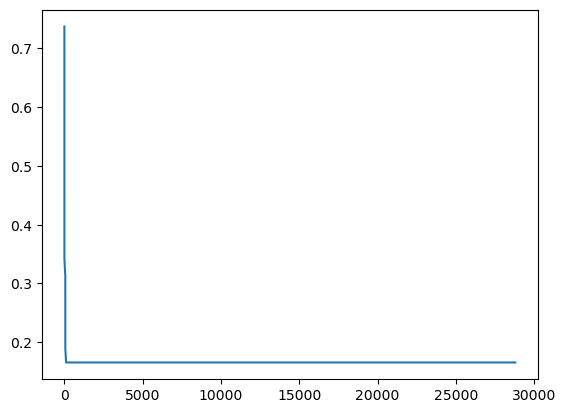

0, (0.16547919568926764, 0, 9706)
(19, 18)


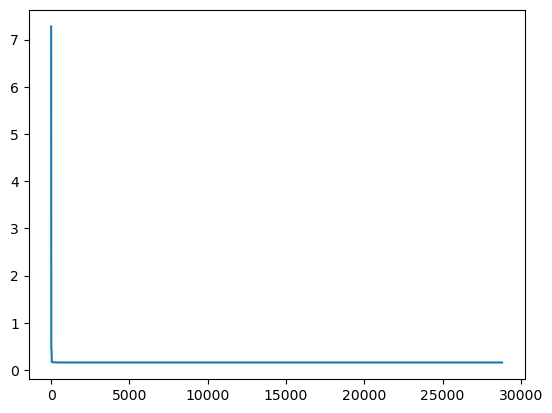

1, (0.15834473049612097, 0, 9560)
(19, 18)


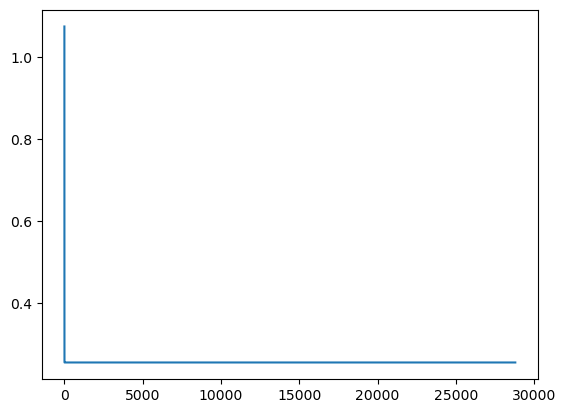

2, (0.25539402775646786, 0, 9662)
(19, 18)


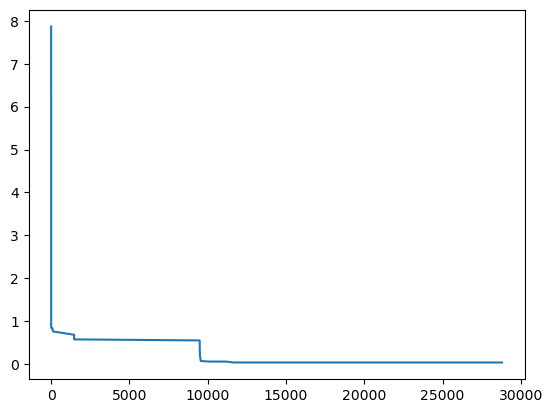

3, (0.028569282070550393, 0, 9674)
(19, 18)


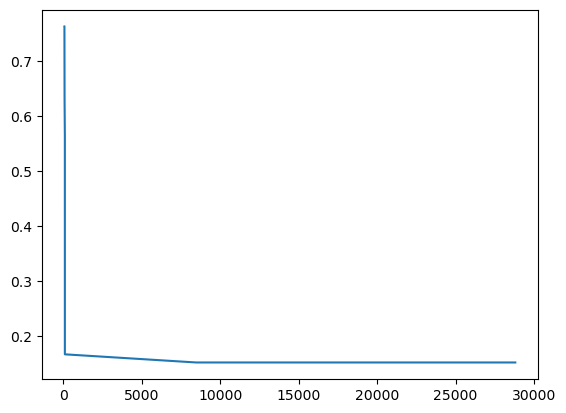

4, (0.1515446495335438, 0, 9651)
(19, 18)


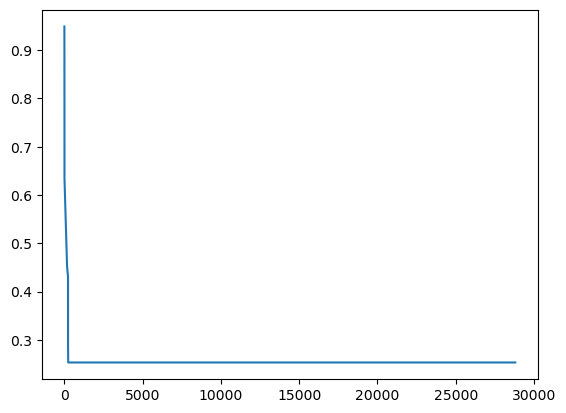

5, (0.25294033495614715, 0, 9655)
(19, 18)


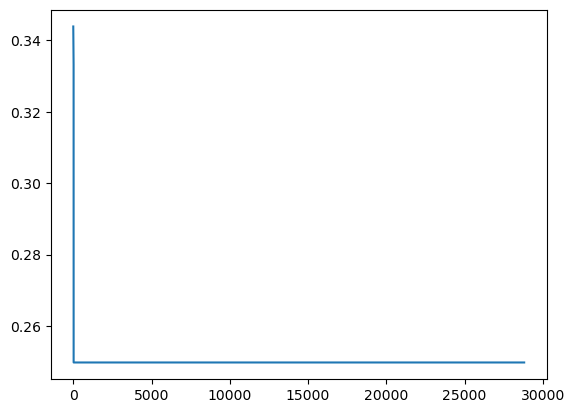

6, (0.24977973062272385, 0, 9622)
(19, 18)


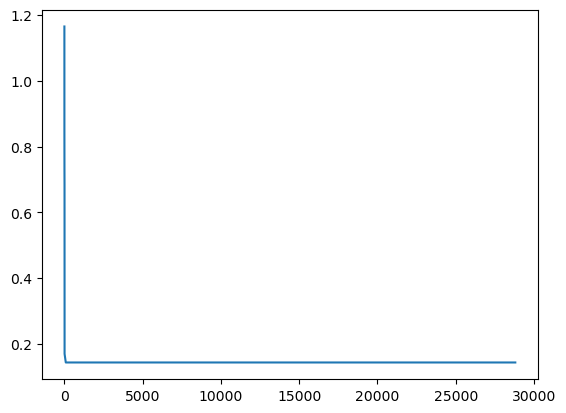

7, (0.14436798273621837, 0, 9513)
(19, 18)


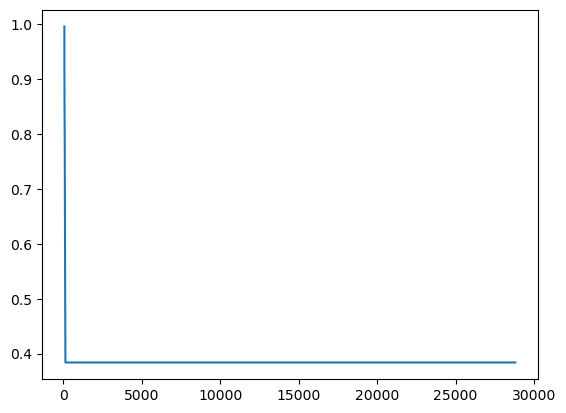

8, (0.38389647575472674, 0, 9640)
(19, 18)


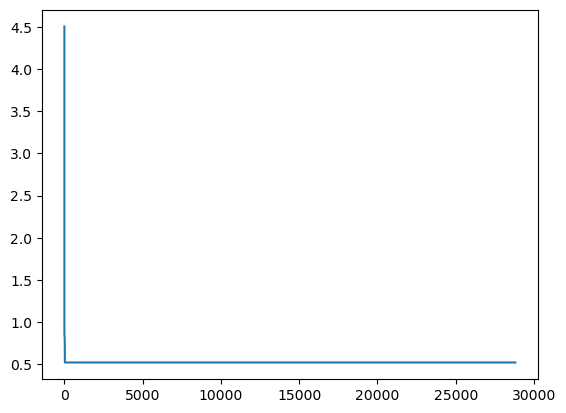

9, (0.5229032366818674, 0, 9737)
(19, 18)


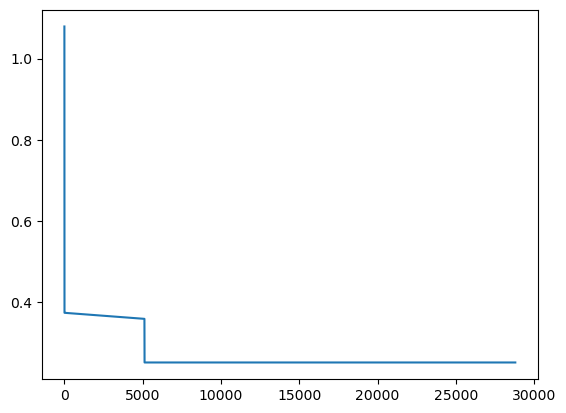

10, (0.25194478117393077, 0, 9574)
(19, 18)


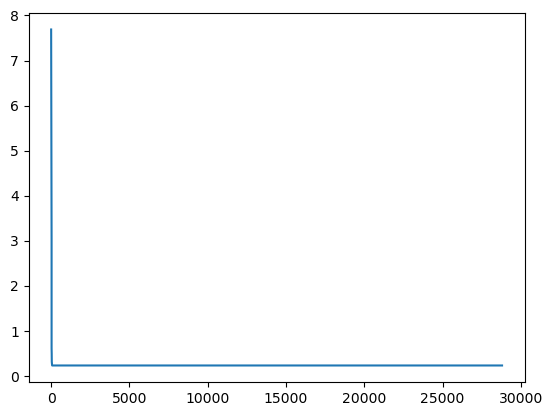

11, (0.23515875841731035, 0, 9589)
(19, 18)


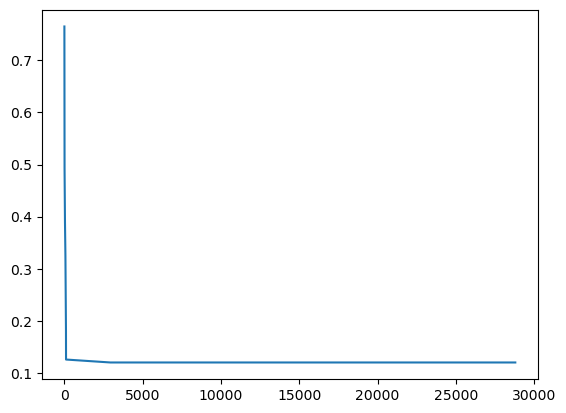

12, (0.11994762529880572, 0, 9626)
(19, 18)


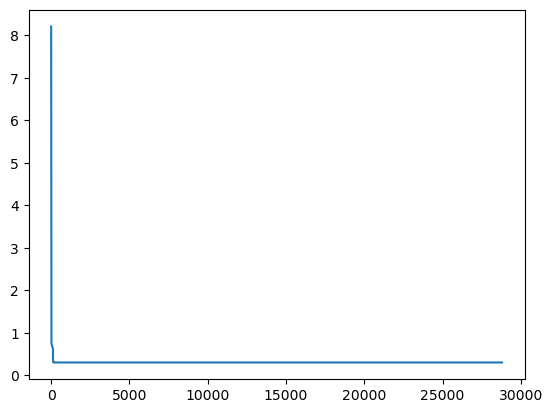

13, (0.30016134402254147, 0, 9706)
(19, 18)


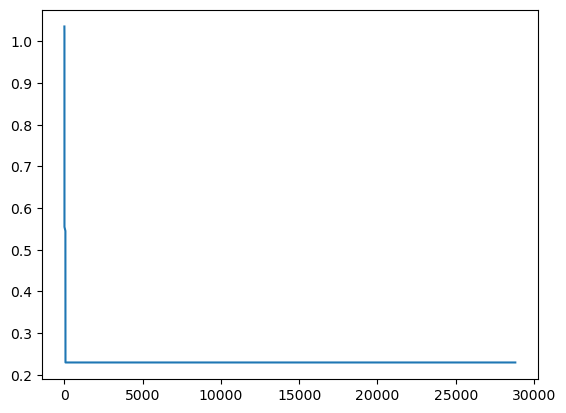

14, (0.22955152410656052, 0, 9659)
(19, 18)


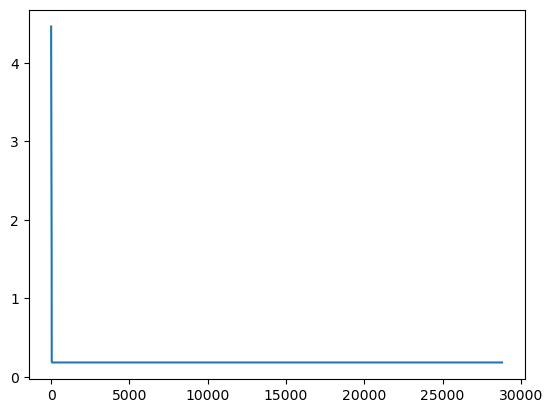

15, (0.18269114077175955, 0, 9576)
(19, 18)


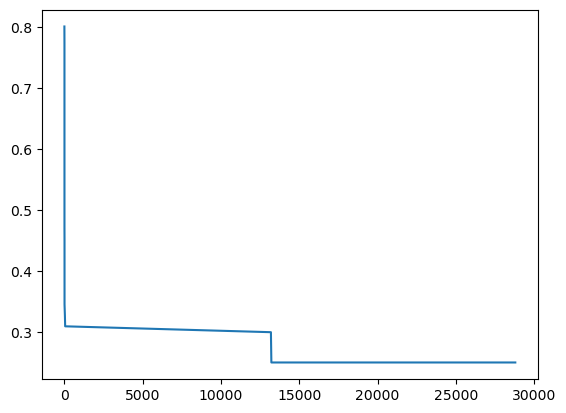

16, (0.25032196470395673, 0, 9515)
(19, 18)


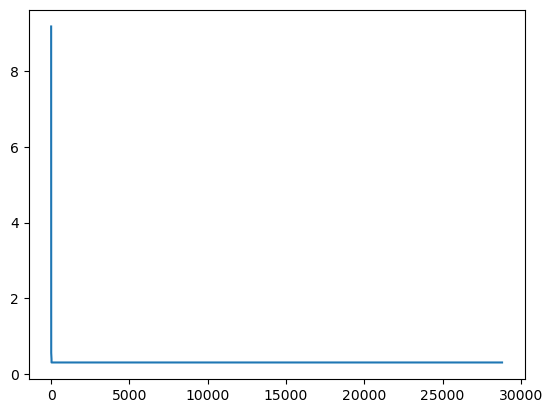

17, (0.299686130849432, 0, 9527)
(19, 18)


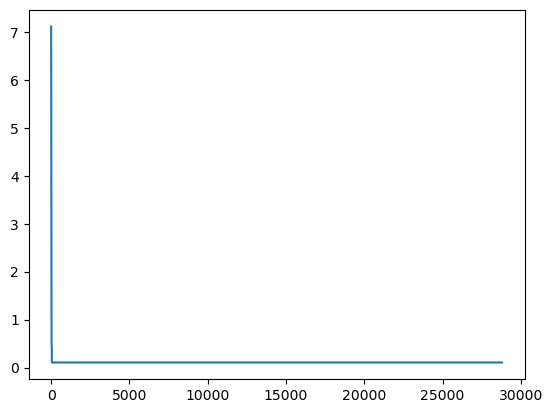

18, (0.10477034391176195, 0, 9602)
(19, 18)


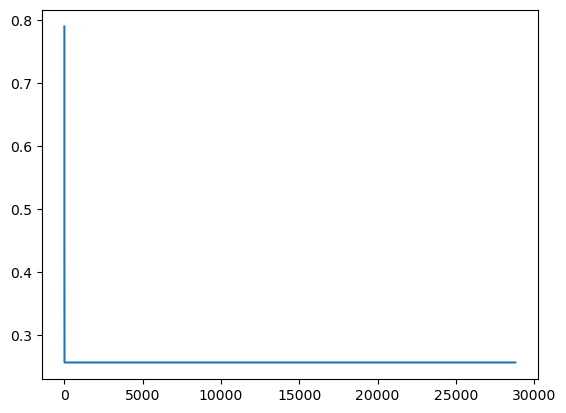

19, (0.256289980893718, 0, 9669)
(19, 18)


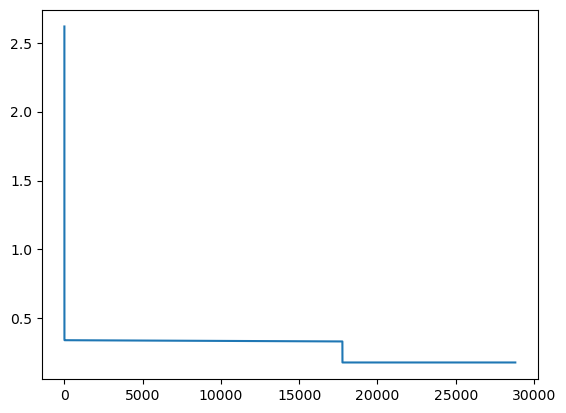

20, (0.18012443235598427, 0, 9700)
(19, 18)


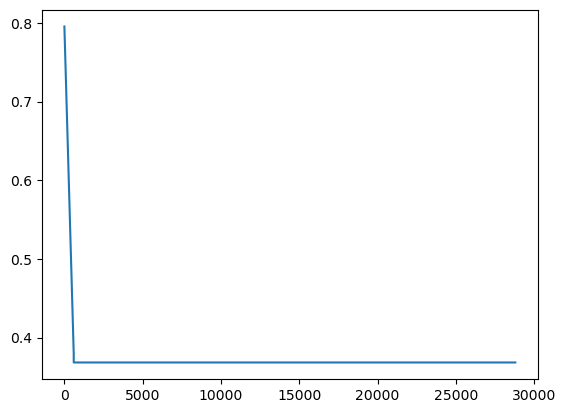

21, (0.3683102430873343, 0, 9594)
(19, 18)


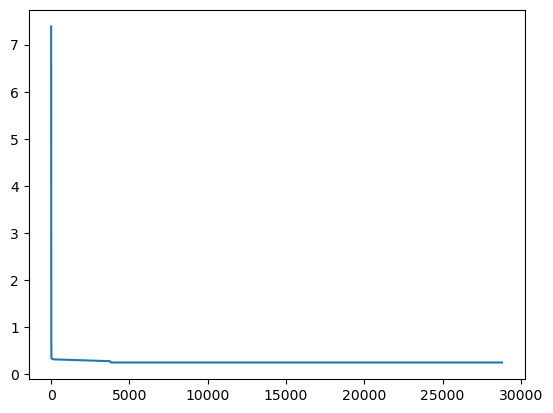

22, (0.2525633679282062, 0, 9579)
(19, 18)


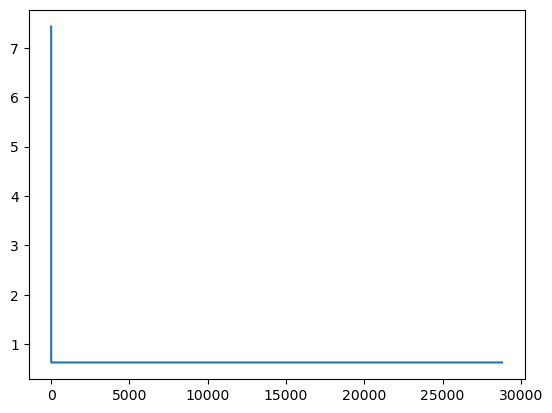

23, (0.6314901358585694, 0, 9624)
(19, 18)


FileNotFoundError: [Errno 2] No such file or directory: '/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/microwave_17x16_class10G_90metal03decayPEC_0614_RANDtrad/seed24.txt'

In [ ]:
for i in range(28):
    ff=open('/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/microwave_17x16_class10G_90metal03decayPEC_0614_RANDtrad/seed'+str(i)+'.txt','rb')
    po1=pickle.load(ff)
    try:
        po1=pickle.load(ff)
    except:
        pass
    ff.close()
    plt.plot(po1['time'],[v[0] for v in po1['perf']])
    plt.show()
    print(str(i)+', '+str(po1['perf'][-1]))
    print(po1['struc'][-1].shape)

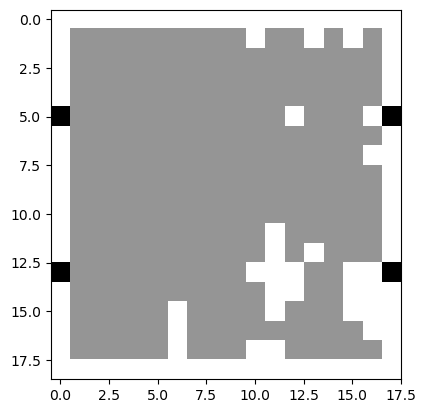

Target: 1, inference: [0.4159844175989319, 0.5840155824010682]
Target: 1, inference: [0.410914700699934, 0.589085299300066]
Target: 1, inference: [0.9623501796738008, 0.03764982032619915]
Target: 1, inference: [0.9787561104269166, 0.021243889573083426]
Target: 0, inference: [0.026681347319079392, 0.9733186526809207]
Target: 0, inference: [0.15865127366185675, 0.8413487263381432]
Target: 1, inference: [0.7521746576909621, 0.24782534230903783]
Target: 1, inference: [0.7644507607689073, 0.23554923923109264]
Target: 1, inference: [0.5458249701347508, 0.45417502986524905]
Target: 1, inference: [0.4790748180474481, 0.520925181952552]
Target: 1, inference: [0.9889420200759992, 0.011057979924000769]
Target: 1, inference: [0.6171819429495145, 0.38281805705048555]
Target: 1, inference: [0.8566576833520763, 0.14334231664792382]
Target: 0, inference: [0.0045640953054307655, 0.9954359046945693]
Target: 1, inference: [0.8500083245167106, 0.14999167548328932]
Target: 1, inference: [0.3089975190646693

In [ ]:
ff=open('/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/microwave_17x16_class10G_90metal03decayPEC_0614_RANDtrad/seed18.txt','rb')
po1=pickle.load(ff)
try:
    po1=pickle.load(ff)
except:
    pass
ff.close()
plt.imshow(po1['struc'][-1],cmap='Greys')
plt.show()
correctPred=[]
for i, (xtl,ytl,ttl) in enumerate(zip(xTrain,yTrain,tTrain)):
    preds=mso.getPredB(po1['struc'][-1],[xtl],[ytl],[ttl])[0]
    print('Target: '+str(ttl)+', inference: '+str(list(preds)))
    if (ttl==1 and preds[0]>preds[1]) or (ttl==0 and preds[1]>preds[0]):
        correctPred.append(1)
    else:
        correctPred.append(0)
print(np.mean(correctPred))

In [ ]:
po1['struc'][-1],[xtl],[ytl],[ttl]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 2.],
        [0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [2., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 2.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 [0.2985

[0.16888871922343007, 0.010132285774675285, 0.11929151188373352]


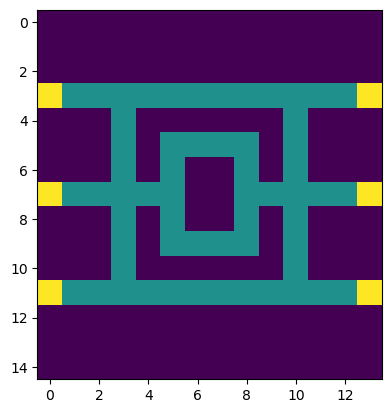

0.5689016194517483
[0.010132324169301724, 0.12545918314309107, 0.010132276718956947]


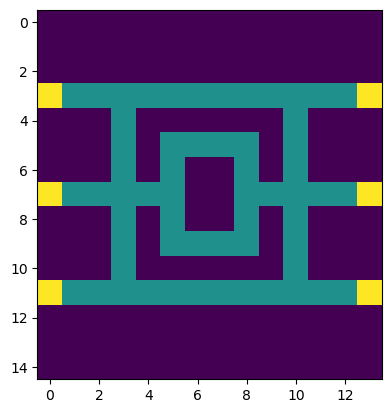

2.6659822133984092
[0.11929150699768022, 0.010132238834129307, 0.1688899116085486]


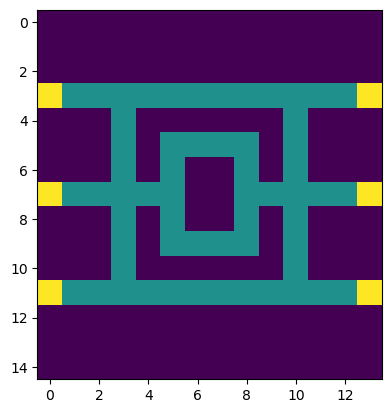

0.9165753384442238
[0.01857236124892198, 0.010132262304279254, 0.018572481043200213]


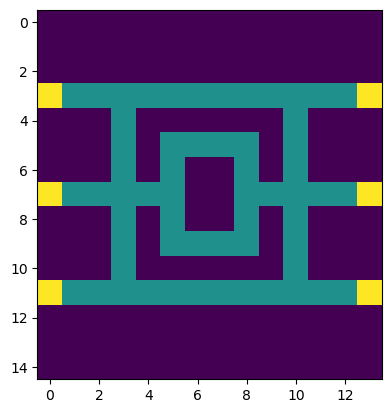

0.9343516104867815


In [ ]:
sm=np.array([[0,0,0,0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0,0,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1],
             [0,0,1,0,0,0,0,0,0,1,0,0],
             [0,0,1,0,1,1,1,1,0,1,0,0],
             [0,0,1,0,1,0,0,1,0,1,0,0],
             [1,1,1,1,1,0,0,1,1,1,1,1],
             [0,0,1,0,1,0,0,1,0,1,0,0],
             [0,0,1,0,1,1,1,1,0,1,0,0],
             [0,0,1,0,0,0,0,0,0,1,0,0],
             [1,1,1,1,1,1,1,1,1,1,1,1],
             [0,0,0,0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0,0,0,0],])
sm=np.pad(sm,((1,1),(1,1)),'constant',constant_values=0)
mso.set_structure(mso.size[0],mso.size[1],setMap=np.where(mso.usetMap<0,sm,mso.usetMap),symmetryAxis=None)
L=0
inputs=[[1,0,0],[0,1,0],[0,0,1],[0.5,0,0.5]]
for i,(inputList,) in enumerate(zip(inputs)):
    for j,(pl,pv) in enumerate(zip(mso.inPLs,inputList)):
        mso.boundaryMap[pl]=('input',pv)
    mso.set_boundary(boundaryMap=mso.boundaryMap)
    _,timing=mso.solve_system(mso.ufreqs)
    dd=mso.get_outputPure()[0]
    print([np.abs(dd[v])**2 for v in mso.outPLs])
    plt.imshow(mso.setMap)
    plt.show()
    #mso.graph_system()
    #mso.plotSize=(16,16)
    #mso.plot_system(8.0)
    print(mso.getCrossEntropy(sm,[inputList,],targets=[[1,0,0]]))

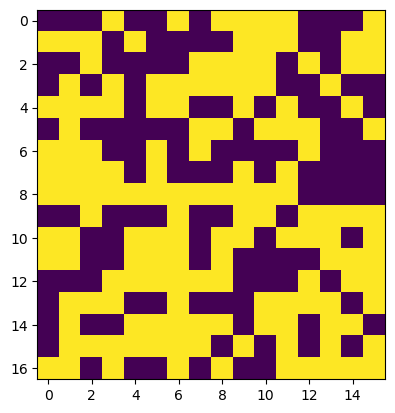

In [ ]:
frozensm=np.random.randint(0,2,(17,16))
plt.imshow(frozensm)

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


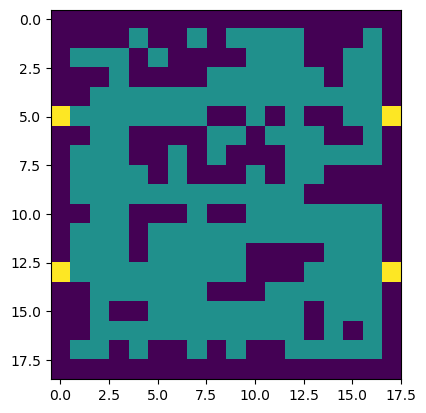

In [ ]:
def buildFor17x16_class10G_PRE():
    portLocations=[(9,0),(25,0),(9,32),(25,32)]
    setMap=-np.ones([17,16])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor17x16_class10G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object                                                                                                                       |
        portParams=[
                    np.array([[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0],[0,1,0,0]]),
                        ]*1
        portLocations2,setMap=buildFor17x16_class10G_PRE()

        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','input','output','output'],portParams=portParams,freq=[10.0],lossless=False)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
mso=buildFor17x16_class10G()
sm=deepcopy(frozensm)
for locs in [(12,0),(12,1),(12,2),(11,2),(10,2),(3,2),(3,4),(4,4),(3,11),(2,11),(3,12),(3,14),(3,15),(4,15),(9,1),(5,2),(6,13),(7,12),(6,11),(6,14),(6,15),(9,11),(10,10),(10,14),(11,7),(10,7),(13,5),(13,4),(14,15),(13,14),(12,13),(14,9),(15,8),(15,10)]:
    sm[locs[0],locs[1]]=1

sm=np.pad(sm,((1,1),(1,1)),'constant',constant_values=0)
mso.set_structure(mso.size[0],mso.size[1],setMap=np.where(mso.usetMap<0,sm,mso.usetMap),symmetryAxis=None)
plt.imshow(mso.setMap)
plt.show()

In [ ]:
ff=open()

[0.2512872523951043, 0.18526092591162485]
[0.3687863819484575, 0.6088812183435802]
[0.3020040362146129, 0.132723258833539]
[0.3453869871741901, 0.5971284425164219]
[0.24698976754197366, 0.11247596482169316]
[0.23531338920724099, 0.1701227122228821]
[0.5214373952251404, 0.49877411146969863]
[0.346628189340366, 0.3762393114272738]
[0.22270275307227488, 0.20610372763846085]
[0.5791868153550402, 0.5925255027082141]
[0.32304021344045547, 0.29270481250962876]
[0.5052599534837444, 0.6106066928512495]
[0.3382275467933037, 0.18271398074992198]
[0.2572475170607401, 0.4294519051013749]
[0.26267276980252574, 0.11452015389727767]
[0.3793454251542663, 0.45419442338046695]
[0.18973073716817168, 0.11651027379541856]
[0.2601286302867207, 0.5611708499918937]
[0.4235970015626686, 0.26591053654694713]
[0.5196608208210395, 0.4667226265756449]
[0.4367792796131376, 0.6007751690246792]
[0.47145572154057047, 0.539700622254398]
[0.3838913876638485, 0.5578010452452162]
[0.2898143547204851, 0.3733320196883027]
[0

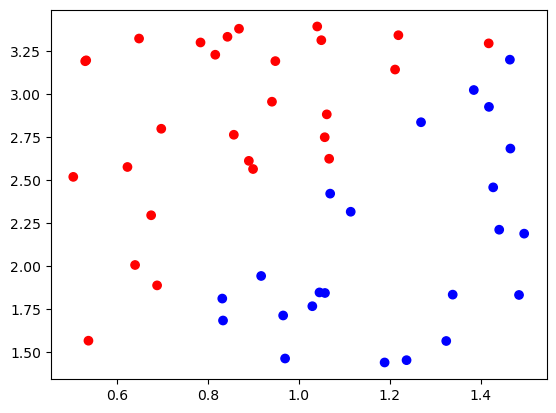

In [ ]:
L=0
inputs=[]
for i in range(50):
    inputs.append((np.random.rand(2)+0.5)*np.array((1,2.0))+np.array([0,0.4]))
outputColors=[]
outputs=[]
outputScores=[]
for i,(inputList,) in enumerate(zip(inputs)):
    for j,(pl,pv) in enumerate(zip(mso.inPLs,inputList)):
        mso.boundaryMap[pl]=('input',pv)
    mso.set_boundary(boundaryMap=mso.boundaryMap)
    _,timing=mso.solve_system(mso.ufreqs)
    dd=mso.get_outputPure()[0]
    vvs=[np.abs(dd[v])**2 for v in mso.outPLs]
    print(vvs)
    #plt.imshow(mso.setMap)
    #plt.show()
    if vvs[1]>vvs[0]:
        outputColors.append('red')
        outputScores.append(1)
    else:
        outputColors.append('blue')
        outputScores.append(0)
    outputs.append(vvs)
    #mso.graph_system()
    #mso.plotSize=(16,16)
    #mso.plot_system(8.0)
    #print(mso.getCrossEntropy(sm,[inputList,],targets=[[1,0,0]]))
plt.scatter([v[0] for v in inputs],[v[1] for v in inputs],c=outputColors)
print(sum(outputScores)/len(outputScores))

[0.08693560809736998, 0.10714675862323783]
[0.09578386269260043, 0.10705213061445502]
[0.10513956157956533, 0.10695837528467969]
[0.11500270475826511, 0.10686549263391536]
[0.12537329222869933, 0.106773482662155]
[0.13625132399086826, 0.1066823453694039]
[0.14763680004477134, 0.10659208075566072]
[0.15952972039040997, 0.10650268882092698]
[0.17193008502778265, 0.1064141695651986]
[0.1848378939568898, 0.10632652298847971]
[0.198253147177732, 0.10623974909076947]
[0.21217584469030848, 0.10615384787206639]
[0.22660598649461988, 0.10606881933236977]
[0.24154357259066586, 0.10598466347168277]
[0.25698860297844645, 0.10590138029000254]
[0.27294107765796166, 0.10581896978733148]
[0.2894009966292114, 0.10573743196366733]
[0.3063683598921954, 0.10565676681901207]
[0.3238431674469146, 0.10557697435336343]
[0.34182541929336907, 0.10549805456672419]
[0.09402902193594737, 0.12393800973611103]
[0.10316102177011657, 0.12383561068982046]
[0.11280046589602015, 0.12373408432253767]
[0.12294735431365882,

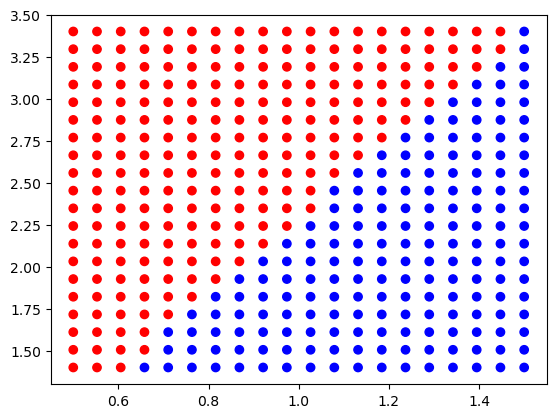

In [ ]:
L=0
inX,inY=np.meshgrid(np.linspace(0.5,1.5,20),np.linspace(2.0*0.5,1.5*2.0,20)+0.4)
inputs=[(xv,yv) for (xv,yv) in zip(inX.flatten(),inY.flatten())]
outputColors=[]
outputs=[]
outputScores=[]
for i,(inputList,) in enumerate(zip(inputs)):
    for j,(pl,pv) in enumerate(zip(mso.inPLs,inputList)):
        mso.boundaryMap[pl]=('input',pv)
    mso.set_boundary(boundaryMap=mso.boundaryMap)
    _,timing=mso.solve_system(mso.ufreqs)
    dd=mso.get_outputPure()[0]
    vvs=[np.abs(dd[v])**2 for v in mso.outPLs]
    print(vvs)
    #plt.imshow(mso.setMap)
    #plt.show()
    if vvs[1]>vvs[0]:
        outputColors.append('red')
        outputScores.append(1)
    else:
        outputColors.append('blue')
        outputScores.append(0)
    outputs.append(vvs)
    #mso.graph_system()
    #mso.plotSize=(16,16)
    #mso.plot_system(8.0)
    #print(mso.getCrossEntropy(sm,[inputList,],targets=[[1,0,0]]))
plt.scatter([v[0] for v in inputs],[v[1] for v in inputs],c=outputColors)
print(sum(outputScores)/len(outputScores))

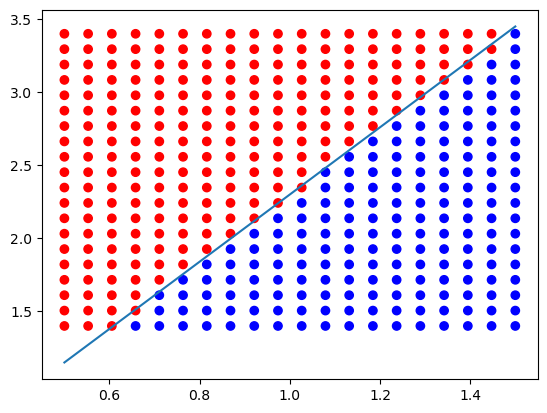

In [ ]:
plt.scatter([v[0] for v in inputs],[v[1] for v in inputs],c=outputColors)
xx=np.linspace(0.5,1.5,20)
yy=2.3*xx+0
plt.plot(xx,yy)
plt.show()

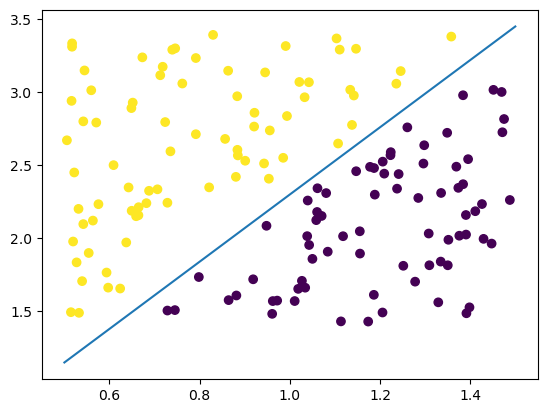

In [ ]:
m=2.3
b=0
def genData(num,pad=0.05):
    xCoord,yCoord,label=[],[],[]
    i=0
    while len(xCoord)<num:
        coord=(np.random.rand(2)+0.5)*np.array((1,2.0))+np.array([0,0.4])
        xx=(-1/m*coord[0]+coord[1]-b)/(m-1/m)
        yy=m*xx+b
        dist=np.sqrt((coord[0]-xx)**2+(coord[1]-yy)**2)
        if dist>pad:
            xCoord.append(coord[0])
            yCoord.append(coord[1])
            if coord[1]>m*coord[0]+b:
                label.append(1)
            else:
                label.append(0)
    return np.array(xCoord),np.array(yCoord),np.array(label)

def trueLine(x,m,b):
    return m*x+b
xPlot=np.linspace(0.5,1.5,100)
yplot=trueLine(xPlot,m,b)
plt.plot(xPlot,yplot)
xCoord,yCoord,label=genData(150)
plt.scatter(xCoord,yCoord,c=label)
plt.show()
ff=open('/home/groundnet/Desktop/Nate/convexPreopt/irisDataShuffled.pkl','wb')
pickle.dump([xCoord,yCoord,label],ff)
ff.close()

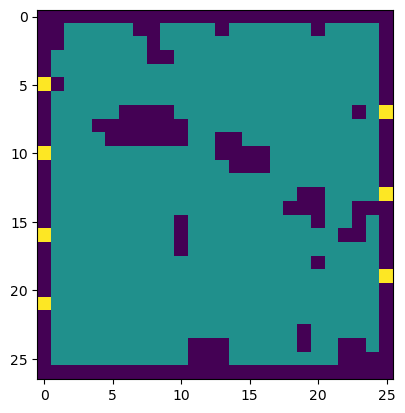

In [ ]:
po=pickle.load(open('/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/microwave_25x24_NN10G_90metal03decayPEC_0614_RANDtrad.txt','rb'))
plt.imshow(po[0][0][0][-1])
plt.show()

### Boundary Search

#### Result Compilation

##Build Funcs

In [ ]:
def processSetMap(portLocations,setMap):
    setMap=np.pad(setMap,((1,1),(1,1)),'constant',constant_values=0)
    portLocations2=[]
    for pl in portLocations:
        if pl[0]==0:
            portLocations2.append((pl[0],pl[1]+2))
            setMap[portLocations2[-1][0]//2,portLocations2[-1][1]//2]=2
        elif pl[1]==0:
            portLocations2.append((pl[0]+2,pl[1]))
            setMap[portLocations2[-1][0]//2,portLocations2[-1][1]//2]=2
        elif pl[0]==(setMap.shape[0]-2)*2:
            portLocations2.append((pl[0]+4,pl[1]+2))
            setMap[portLocations2[-1][0]//2-1,portLocations2[-1][1]//2]=2
        elif pl[1]==(setMap.shape[1]-2)*2:
            portLocations2.append((pl[0]+2,pl[1]+4))
            setMap[portLocations2[-1][0]//2,portLocations2[-1][1]//2-1]=2
    return portLocations2,setMap

def buildMSOCPW(mso,setMap,portLocations2,symmetryAxis,portTypes,portParams,freq,lossless=False,whichImpedance=0):
    mso.add_structure(setMap,symmetryAxis=symmetryAxis) #We now add the setMap to mso
    #This is where we define port locations (using the grid, not the vector), the type, load up out portParams, and determine frequency (or frequencies)
    mso.add_ports(portLocations=portLocations2,portTypes=portTypes,portParams=portParams,freq=freq)
    try:
        mso.add_sMats(['/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPW_F.snp','/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPW.snp']) #coptEnv
    except:
        mso.setName=0
        mso.add_sMats(['/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC_F.snp','/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC.snp'])
    mso.sMats[2]={}
    for fr in mso.freqs:
        mso.sMats[2][fr]=np.array([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
    mso.setName=3
    try:
        impedanceSmats=['/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_12p5In.snp','/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_12p5In_impedanceOrientation.snp','/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_25InB.snp',]
        mso.add_sMats([impedanceSmats[whichImpedance]])
    except:
        mso.setName=3
        impedanceSmats=['/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC_12p5In.snp','/home/hal90000/Desktop/Nate/micropatchDev/element4WG/element4LFreeCPWPEC_12p5In_impedanceOrientation.snp']
        mso.add_sMats([impedanceSmats[whichImpedance]])
    if lossless:
        for fr in mso.freqs:
            for l in range(2):
                mso.sMats[l][fr]=scipy.linalg.polar(mso.sMats[l][fr])[0]
            mso.sMats[3][fr]=scipy.linalg.polar(mso.sMats[3][fr])[0]
    return mso

In [ ]:


def touchstone2array(filename):
    """
    Read an N-port Touchstone file (extension .sNp or .snp) and return a dict:
        { frequency_float:  N×N complex‐valued S-matrix (numpy.ndarray) }

    - Skips comment lines beginning with '!' and the option‐header line beginning with '#'.
    - Supports data formats RI, MA, and DB (given by the 4th token on the '#' line).
    - For N = 1 or 2, expects all data for each frequency on a single line.
    - For N ≥ 3, expects data in matrix form: first row on one line (freq + 2N values),
      then the remaining N−1 rows on successive non‐comment lines (each with 2N values).
    """
    # Helper: convert one (v0, v1) pair to complex, depending on data_format
    def pair_to_complex(v0, v1, data_format):
        if data_format == 'RI':
            # Real/Imaginary
            real = float(v0)
            imag = float(v1)
            return real + 1j * imag
        elif data_format == 'MA':
            # Magnitude / Angle (degrees)
            mag = float(v0)
            ang_deg = float(v1)
            return mag * np.exp(1j * np.deg2rad(ang_deg))
        elif data_format == 'DB':
            # dB / Angle (degrees) → convert dB ▶ linear magnitude
            db = float(v0)
            ang_deg = float(v1)
            mag = 10 ** (db / 20.0)
            return mag * np.exp(1j * np.deg2rad(ang_deg))
        else:
            raise ValueError(f"Unsupported data format: '{data_format}'")

    # Read all lines, strip newline characters
    with open(filename, 'r') as f:
        raw_lines = f.readlines()

    # Parse header: skip all lines until we find the option line (starts with '#')
    data_format = None
    idx = 0
    while idx < len(raw_lines):
        line = raw_lines[idx].strip()
        if not line or line.startswith('!'):
            idx += 1
            continue
        if line.startswith('#'):
            tokens = line.lstrip('#').strip().upper().split()
            # tokens[0] = frequency unit, tokens[1] = 'S' (we only handle scattering),
            # tokens[2] = data format (RI, MA, or DB), tokens[3:] may include 'R' and ref_impedance
            if len(tokens) < 3:
                raise ValueError("Malformed option line (missing data format).")
            data_format = tokens[2]
            idx += 1
            break
        else:
            raise ValueError("Expected option line beginning with '#', but found:\n  " + line)

    if data_format not in {'RI', 'MA', 'DB'}:
        raise ValueError(f"Option line specifies unsupported data format '{data_format}'")

    # Now idx points to the first line after the option line. We'll iterate through lines
    sData = {}
    line1 = raw_lines[idx].strip()
    tokens1 = line1.split()
    line2= raw_lines[idx+1].strip()
    tokens2 = line2.split()
    if len(tokens2)%2!=0:
        if len(tokens1)==2:
            N=1
        else:
            N=2
    else:
        N=len(tokens2)//2
    # Outer loop: scan until end of file
    while idx < len(raw_lines):
        line = raw_lines[idx].strip()
        if not line or line.startswith('!'):
            idx += 1
            continue

        # First non‐comment line: interpret as start of a data block for one frequency
        tokens = line.split()
        # Infer number of ports N from the number of numeric tokens:
        #   For each data line, #tokens = 1 (freq) + 2*N  if N ≤ 2 (all pairs on one line)
        #   For N ≥ 3, the first data row is: 1 (freq) + 2*N entries
        # Hence N = (len(tokens) - 1) // 2
        if len(tokens) < 3:
            raise ValueError(f"Data line too short to infer ports: '{line}'")
        if N < 1:
            raise ValueError(f"Cannot infer valid port count from tokens: {tokens}")

        # Handle N=1 or N=2 (all data on one line):
        if N <= 2:
            freq = float(tokens[0])
            # There should be exactly 2 * (N*N) numeric values after freq
            expected_pairs = N * N
            if len(tokens) != 1 + 2 * expected_pairs:
                raise ValueError(
                    f"Expected {1 + 2*expected_pairs} tokens for {N}-port single-line entry, "
                    f"but found {len(tokens)}: '{line}'"
                )
            # Build an empty S-matrix
            smat = np.zeros((N, N), dtype=complex)
            # Extract all pairs in the order they appear
            # For N=1: order = [ S11 ]
            # For N=2: order = [ S11, S21, S12, S22 ]  (column-major!) :contentReference[oaicite:0]{index=0}
            raw_vals = tokens[1:]  # length = 2 * (N*N)
            pairs = []
            for k in range(expected_pairs):
                v0 = raw_vals[2*k]
                v1 = raw_vals[2*k + 1]
                pairs.append(pair_to_complex(v0, v1, data_format))
            if N == 1:
                smat[0, 0] = pairs[0]
            else:  # N == 2
                # column-major assignment: (row, col)
                smat[0, 0] = pairs[0]  # S11
                smat[1, 0] = pairs[1]  # S21
                smat[0, 1] = pairs[2]  # S12
                smat[1, 1] = pairs[3]  # S22
            sData[freq] = smat
            idx += 1
            continue
        # Otherwise N >= 3: first line holds row 1 (freq + 2*N values)
        #   then the next N-1 non‐comment lines each hold 2*N values for rows 2..N :contentReference[oaicite:1]{index=1}
        freq = float(tokens[0])
        row_tokens = tokens[1:]
        if len(row_tokens) != 2 * N:
            raise ValueError(
                f"Expected {2*N} data tokens for port‐row 1, but got {len(row_tokens)}: '{line}'"
            )

        # Initialize S-matrix
        smat = np.zeros((N, N), dtype=complex)
        # Fill in row 1 (i = 0)
        for col in range(N):
            v0 = row_tokens[2*col]
            v1 = row_tokens[2*col + 1]
            smat[0, col] = pair_to_complex(v0, v1, data_format)

        # Read the remaining N−1 rows
        row_count = 1
        idx += 1
        while row_count < N and idx < len(raw_lines):
            next_line = raw_lines[idx].strip()
            if not next_line or next_line.startswith('!'):
                idx += 1
                continue
            row_vals = next_line.split()
            if len(row_vals) != 2 * N:
                raise ValueError(
                    f"Expected {2*N} data tokens for port‐row {row_count+1}, but got {len(row_vals)}: '{next_line}'"
                )
            for col in range(N):
                v0 = row_vals[2*col]
                v1 = row_vals[2*col + 1]
                smat[row_count, col] = pair_to_complex(v0, v1, data_format)
            row_count += 1
            idx += 1

        if row_count != N:
            raise ValueError(
                f"Ran out of lines before gathering all {N} rows for frequency {freq}"
            )

        sData[freq] = smat

    return sData



In [ ]:
def draw_pcb(ax,pattern):
    """
    Render a 15×15 micropatch array.

    Parameters
    ----------
    pattern : array‑like (15, 15) with entries {0, 1, 2}
        0 – empty
        1 – crossed bars + centre circle
        2 – single bar:
            horizontal  if ((y>x  and y<15‑x) or (y>15‑x and y<x))
            vertical    otherwise
        with (x, y) measured from bottom‑left, 0‑based.
    """
    shape=pattern.shape
    pattern = np.asarray(pattern)

    # geometry & colours
    cell, bar, gap = 1.5, 0.3, 0.2
    copper, pcb_green = '#e6b60b', '#0a4721'
    ground='#dbcc97'
    ax.set_xlim(0, shape[1] * cell)
    ax.set_ylim(0, shape[0] * cell)
    ax.set_aspect('equal')
    ax.set_facecolor(pcb_green)
    ax.axis('off')

    for r in range(shape[0]):            # r = row index (top → bottom)
        for c in range(shape[1]):        # c = column index (left → right)
            val = pattern[r, c]


            # convert to bottom‑left origin for rule tests
            xcell, ycell = c, shape[0]-1 - r
            x0, y0 = c * cell, ycell * cell
            if val==0 and r!=0 and r!=shape[0]-1 and c!=0 and c!=shape[1]-1:
                ax.add_patch(Rectangle((x0+gap, y0+gap),
                                        cell-2*gap, cell-2*gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0 , y0),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0+cell/2+bar/2+gap , y0),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0+cell/2+bar/2+gap , y0+cell/2+bar/2+gap),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0 , y0+cell/2+bar/2+gap),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
            elif val == 1:           # crossed bars + circle
                ax.add_patch(Rectangle((x0, y0 + (cell - bar)/2),
                                        cell, bar, facecolor=copper, lw=0))
                ax.add_patch(Rectangle((x0 + (cell - bar)/2, y0),
                                        bar, cell, facecolor=copper, lw=0))

                ax.add_patch(Rectangle((x0 , y0),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0+cell/2+bar/2+gap , y0),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0+cell/2+bar/2+gap , y0+cell/2+bar/2+gap),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))
                ax.add_patch(Rectangle((x0 , y0+cell/2+bar/2+gap),
                                        cell/2-bar/2-gap, cell/2-bar/2-gap, facecolor=ground, lw=0))

            elif val == 2:         # single bar
                horiz = ((ycell > xcell and ycell < shape[1] - xcell) or
                         (ycell >= shape[0] - xcell and ycell < xcell))
                if xcell==shape[1]-1 or xcell==0:
                    horiz=True
                else:
                    horiz=False
                if horiz:          # horizontal bar
                    ax.add_patch(Rectangle((x0, y0 + (cell - bar)/2),
                                            cell, bar, facecolor=copper, lw=0))
                    ax.add_patch(Rectangle((x0, y0),
                                            cell, cell/2-bar/2-gap, facecolor=ground, lw=0))
                    ax.add_patch(Rectangle((x0, y0+cell/2+bar/2+gap),
                                            cell, cell/2-bar/2-gap, facecolor=ground, lw=0))
                else:              # vertical bar
                    ax.add_patch(Rectangle((x0 + (cell - bar)/2, y0),
                                            bar, cell, facecolor=copper, lw=0))
                    ax.add_patch(Rectangle((x0, y0),
                                            cell/2-bar/2-gap,cell, facecolor=ground, lw=0))
                    ax.add_patch(Rectangle((x0+cell/2+bar/2+gap, y0),
                                            cell/2-bar/2-gap,cell, facecolor=ground, lw=0))

    return ax

In [ ]:
def parseTradResults(ffn):
    ff=open(ffn,'rb')
    po=pickle.load(ff)
    ff.close()
    usepo=po
    bestSet,bestv=(0,0,0),np.inf
    allObjs,allTimes=[],[]
    for rSeed,rss in enumerate(po):
        for thread, ts in enumerate(rss):
            useStep=None
            thisBest=ts[1][-1][0]
            if ts[1][-2][0]<thisBest:
                thisBest=ts[1][-2][0]
                useStep=-1
            if thisBest<bestv:
                bestv=deepcopy(thisBest)
                bestSet=(rSeed,thread,useStep)
            allObjs.append([v[0] for v in ts[1][:useStep]])
            allTimes.append(ts[2][:useStep])
    return po[bestSet[0]][bestSet[1]][0][-1],po[bestSet[0]][bestSet[1]][2][:bestSet[2]],[v[0] for v in po[bestSet[0]][bestSet[1]][1][:bestSet[2]]],allObjs,allTimes

In [ ]:
def scrub_touchstone_snp(path, num_ports, output_path=None):
    """
    Read a Touchstone .sNp file and re-assemble any broken-up data lines
    so that each frequency record has exactly 1 + 2·(num_ports**2) tokens.

    Parameters
    ----------
    path : str
        Path to the original .sNp file.
    num_ports : int
        Number of ports (N).  Each S-matrix is N×N, so there are 2·N² real numbers per frequency.
    output_path : str, optional
        If given, the cleaned file is written there.

    Returns
    -------
    List[str]
        Cleaned file as a list of lines (including comments & header).
    """
    tokens_per_record = 1 + 2 * (num_ports ** 2)
    tokens_per_line=2*num_ports
    cleaned = []
    buf = []

    with open(path, 'r') as f:
        for raw in f:
            stripped = raw.strip()
            if not stripped or stripped.startswith(('!', '#')):
                # header/comment → copy verbatim
                cleaned.append(raw)
            else:
                # data line → split and buffer tokens
                toks = stripped.split()
                buf.extend(toks)
                # emit full records
                while len(buf) >= tokens_per_line:
                    rec = buf[:tokens_per_record]
                    cleaned.append(' '.join(rec) + '\n')
                    buf = buf[tokens_per_record:]

    if buf:
        raise ValueError(
            f"Leftover tokens after parsing with num_ports={num_ports}: {len(buf)} tokens"
        )

    if output_path:
        with open(output_path, 'w') as fout:
            fout.writelines(cleaned)

    return cleaned

In [ ]:
def plotFile(ffn,useBuildFunc,sdppos,addExperimental=None,equivTime=None,plotFloor=None,magVlines=[],magHlines=[],phaseVlines=[],phaseHlines=[],legend=False,saveAs=None,noS11Phase=True,yesPhase=True,
             xlims=None,ylims=None,logy=False,fontsize=14,size=None,xlabels=None,limitTrad=None,multiSDP=False,logx=True):
    if not os.path.exists(saveAs):
        os.makedirs(saveAs)
    if size==None:
        size=(12,2.4)
    if yesPhase:
        fig,ax=plt.subplots(nrows=1,ncols=3+int(yesPhase),figsize=size,width_ratios=[3/16,4/16,4/16,3.6/16])
    else:
        fig,ax=plt.subplots(nrows=1,ncols=3+int(yesPhase),figsize=size,width_ratios=[2/16,9/16,5/16],gridspec_kw={'wspace':0.4})
    useArr,times,obj,allObjs,allTimes=parseTradResults(ffn)
    allObjs=allObjs[:limitTrad]
    allTimes=allTimes[:limitTrad]
    if not multiSDP:
        sdppo=sdppos
    else:
        bestInd=0
        bestVal=np.inf
        allObjsSDP,allTimesSDP=[],[]
        for i,sdppo in enumerate(sdppos):
            allObjsSDP.append([v[0] for v in sdppo[1]])
            allTimesSDP.append(sdppo[2])
            if sdppo[1][-1][0]<bestVal:
                bestVal=sdppo[1][-1][0]
                bestInd=i
        sdppo=sdppos[bestInd]
    useArr=sdppo[0][-1]
    times=np.array(sdppo[2])
    obj=np.array([v[0] for v in sdppo[1]])
    mso=useBuildFunc()
    if mso.usetMap.shape!=useArr.shape:
        if mso.usetMap.shape[0]>useArr.shape[0]:
            useArr=np.pad(useArr,((1,1),(1,1)))
        else:
            useArr=useArr[1:-1,1:-1]
    ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)
    #t1=datetime.datetime.now()
    try:
        ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)
    except:
        useArr=np.hstack([useArr,np.flip(useArr,axis=1)])
        useArr=np.vstack([useArr,np.flip(useArr[:-1],axis=0)])
        ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)
    useArr=np.where(useArr==3,1,useArr)
    #ts.append(datetime.datetime.now()-t1)
    smat=np.zeros((len(mso.portTypes),len(sp)),dtype=np.complex64)
    freqs=[]
    for frq,ss in enumerate(sp):
        for pp,v in enumerate(ss):
            smat[pp,frq]=deepcopy(v)
        freqs.append(mso.ufreqs[frq])
    ax[0]=draw_pcb(ax[0],useArr)
    for pp,sr in enumerate(smat):
        ax[1].plot(freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)
        if addExperimental is not None:
            xs=np.array(list(addExperimental.keys()))
            ys=np.array([addExperimental[ff][0,pp] for ff in xs])
            minSMMFreq=min(freqs)
            maxSMMFreq=max(freqs)
            indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
            xs=xs[indArr]
            ys=ys[indArr]
            ax[1].scatter(xs,20*np.log10(np.abs(ys)),alpha=0.7,marker='.', facecolors='C'+str(pp),edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=24)
    for vlp in magVlines:
        ax[1].axvline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
    for vlp in magHlines:
        ax[1].axhline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
    ax[1].set_xlabel('Frequency (GHz)',fontsize=fontsize)
    ax[1].set_ylabel('Magnitude (dB)',fontsize=fontsize)
    if legend:
        ax[1].legend(ncol=1+int(addExperimental is not None))
    if xlabels is not None:
        ax[1].set_xticks(xlabels)
    if yesPhase:
        for pp,sr in enumerate(smat):
            if pp==0 and noS11Phase:
                continue
            ax[2].plot(freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp))
            if addExperimental is not None:
                xs=np.array(list(addExperimental.keys()))
                ys=np.array([addExperimental[ff][0,pp] for ff in xs])
                minSMMFreq=min(freqs)
                maxSMMFreq=max(freqs)
                indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
                xs=xs[indArr]
                ys=ys[indArr]
                ax[2].scatter(xs,np.angle(ys,deg=True),alpha=0.7,marker='.', facecolors='C'+str(pp),edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=24)
        ax[2].set_xlabel('Frequency (GHz)',fontsize=fontsize)
        ax[2].set_ylabel('Angle (deg)',fontsize=fontsize)
        if legend:
            ax[2].legend(ncol=1+int(addExperimental is not None))
        for vlp in phaseVlines:
            ax[2].axvline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        for vlp in phaseHlines:
            ax[2].axhline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        ax[2].set_yticks([-90,0,90])
        if xlabels is not None:
            ax[2].set_xticks(xlabels)
    for objL,timeL in zip(allObjs,allTimes):
        ax[2+int(yesPhase)].plot(timeL[:],objL[:],color='red',alpha=0.15)
    if not multiSDP:
        ax[2+int(yesPhase)].plot(times[:],obj[:],label='SMM',color='blue')
    else:
        for objS,timeS in zip(allObjsSDP,allTimesSDP):
            ax[2+int(yesPhase)].plot(timeS[:],objS[:],color='blue',alpha=0.3)
    if equivTime is not None:
        ax[2+int(yesPhase)].plot((np.array(list(range(len(obj)-1)))+1)*equivTime,obj[:],label='BEM (estimated)')
        ax[2+int(yesPhase)].legend()
    if plotFloor is not None:
        ax[2+int(yesPhase)].axhline(plotFloor,color='Black',linestyle='--',alpha=0.3)
    if logx:
        ax[2+int(yesPhase)].set_xscale('log')
    ax[2+int(yesPhase)].set_xlabel('Time (s)',fontsize=fontsize)
    ax[2+int(yesPhase)].set_ylabel('Objective',fontsize=fontsize)
    for axc in ax:
        axc.tick_params(axis='both', which='major', labelsize=fontsize)
    if xlims is not None:
        ax[2+int(yesPhase)].set_xlim(xlims)
    if ylims is not None:
        ax[2+int(yesPhase)].set_ylim(ylims)
    if logy:
        ax[2+int(yesPhase)].set_yscale('log')

    fig.tight_layout()
    # make sure the renderer knows where everything is
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # now loop and save each panel by cropping
    nms=['/pcb.png','/mag.png','/ang.png','/obj.png']
    if yesPhase:
        nms=['/pcb.png','/mag.png','/ang.png','/obj.png']
    else:
        nms=['/pcb.png','/mag.png','/obj.png']
    for i, axv in enumerate(ax):
        # get the bounding box of the Axes in figure coordinates
        bbox_pix = axv.get_tightbbox(renderer).expanded(1.05, 1.05)

        # 2. convert pixels → inches via the figure's dpi transform
        bbox_in = bbox_pix.transformed(fig.dpi_scale_trans.inverted())
        # save just that region
        fig.savefig(saveAs+nms[i],
                    bbox_inches=bbox_in,dpi=300)
        # (you can tweak those expansion factors to get your margins right)
    plt.show()
    return mso

In [ ]:
class plotFuncs:
    def __init__(self,ffn,useBuildFunc,sdppos,addExperimental=None,equivTime=None,plotFloor=None,magVlines=[],magHlines=[],phaseVlines=[],phaseHlines=[],legend=False,saveAs=None,noS11Phase=True,yesPhase=True,
             xlims=None,ylims=None,logy=False,fontsize=14,size=None,xlabels=None,limitTrad=None,multiSDP=False,logx=True):
        self.ffn,self.useBuildFunc,self.sdppos,self.addExperimental,self.equivTime,self.plotFloor,self.magVlines,self.magHlines,self.phaseVlines,self.phaseHlines,self.legend,self.saveAs,self.noS11Phase,self.yesPhase,self.xlims,self.ylims,self.logy,self.fontsize,self.size,self.xlabels,self.limitTrad,self.multiSDP,self.logx=ffn,useBuildFunc,sdppos,addExperimental,equivTime,plotFloor,magVlines,magHlines,phaseVlines,phaseHlines,legend,saveAs,noS11Phase,yesPhase,xlims,ylims,logy,fontsize,size,xlabels,limitTrad,multiSDP,logx
        if not os.path.exists(saveAs):
            os.makedirs(saveAs)
        if size==None:
            self.size=(12,2.4)
        self.useArr,self.times,self.obj,self.allObjs,self.allTimes=parseTradResults(ffn)
        self.allObjs=self.allObjs[:limitTrad]
        self.allTimes=self.allTimes[:limitTrad]
        if not multiSDP:
            self.sdppo=self.sdppos
        else:
            self.bestInd=0
            self.bestVal=np.inf
            self.allObjsSDP,self.allTimesSDP=[],[]
            for i,sdppo in enumerate(self.sdppos):
                self.allObjsSDP.append([v[0] for v in sdppo[1]])
                self.allTimesSDP.append(sdppo[2])
                if sdppo[1][-1][0]<self.bestVal:
                    self.bestVal=sdppo[1][-1][0]
                    self.bestInd=i
            self.sdppo=self.sdppos[self.bestInd]
        self.useArr=self.sdppo[0][-1]
        self.times=np.array(self.sdppo[2])
        self.obj=np.array([v[0] for v in self.sdppo[1]])
        self.mso=useBuildFunc()
        if self.mso.usetMap.shape!=self.useArr.shape:
            if self.mso.usetMap.shape[0]>self.useArr.shape[0]:
                self.useArr=np.pad(self.useArr,((1,1),(1,1)))
            else:
                self.useArr=self.useArr[1:-1,1:-1]
        ov,sp=self.mso.getSO(self.useArr,useA0=False,sdpObj=False)
        #t1=datetime.datetime.now()
        try:
            ov,sp=self.mso.getSO(self.useArr,useA0=False,sdpObj=False)
        except:
            self.useArr=np.hstack([self.useArr,np.flip(self.useArr,axis=1)])
            self.useArr=np.vstack([self.useArr,np.flip(self.useArr[:-1],axis=0)])
            ov,sp=self.mso.getSO(self.useArr,useA0=False,sdpObj=False)
        self.useArr=np.where(self.useArr==3,1,self.useArr)
        #ts.append(datetime.datetime.now()-t1)
        self.smat=np.zeros((len(self.mso.portTypes),len(sp)),dtype=np.complex64)
        self.freqs=[]
        for frq,ss in enumerate(sp):
            for pp,v in enumerate(ss):
                self.smat[pp,frq]=deepcopy(v)
            self.freqs.append(self.mso.ufreqs[frq])
        return


    def render(self,fig,ax,nm,show):
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        ax.tick_params(axis='both', which='major', labelsize=self.fontsize)
        bbox_pix = ax.get_tightbbox(renderer).expanded(1.05, 1.05)

        # 2. convert pixels → inches via the figure's dpi transform
        bbox_in = bbox_pix.transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(nm,
                    bbox_inches=bbox_in,dpi=300)
        if show:
            plt.show()
        return

    def plotPCB(self,size,show=False):
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=size)
        ax=draw_pcb(ax,self.useArr)
        self.render(fig,ax,self.saveAs+'/pcb.png',show)
        return

    def plotMag(self,size,show=False):
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=size)
        for pp,sr in enumerate(self.smat):
            ax.plot(self.freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)
            if self.addExperimental is not None:
                xs=np.array(list(self.addExperimental.keys()))
                ys=np.array([self.addExperimental[ff][0,pp] for ff in xs])
                minSMMFreq=min(self.freqs)
                maxSMMFreq=max(self.freqs)
                indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
                xs=xs[indArr]
                ys=ys[indArr]
                ax.scatter(xs,20*np.log10(np.abs(ys)),alpha=0.7,marker='.', facecolors='C'+str(pp),edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=24)
        for vlp in self.magVlines:
            ax.axvline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        for vlp in self.magHlines:
            ax.axhline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        ax.set_xlabel('Frequency (GHz)',fontsize=self.fontsize)
        ax.set_ylabel('Magnitude (dB)',fontsize=self.fontsize)
        if self.legend:
            ax.legend(ncol=1+int(self.addExperimental is not None))
        if self.xlabels is not None:
            ax.set_xticks(self.xlabels)
        self.render(fig,ax,self.saveAs+'/mag.png',show)
        return

    def plotAng(self,size,show=False):
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=size)
        for pp,sr in enumerate(self.smat):
            if pp==0 and self.noS11Phase:
                continue
            ax.plot(self.freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp))
            if self.addExperimental is not None:
                xs=np.array(list(self.addExperimental.keys()))
                ys=np.array([self.addExperimental[ff][0,pp] for ff in xs])
                minSMMFreq=min(self.freqs)
                maxSMMFreq=max(self.freqs)
                indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
                xs=xs[indArr]
                ys=ys[indArr]
                ax.scatter(xs,np.angle(ys,deg=True),alpha=0.7,marker='.', facecolors='C'+str(pp),edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=24)
        ax.set_xlabel('Frequency (GHz)',fontsize=self.fontsize)
        ax.set_ylabel('Angle (deg)',fontsize=self.fontsize)
        if self.legend:
            ax.legend(ncol=1+int(self.addExperimental is not None))
        for vlp in self.phaseVlines:
            ax.axvline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        for vlp in self.phaseHlines:
            ax.axhline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        ax.set_yticks([-90,0,90])
        if self.xlabels is not None:
            ax.set_xticks(self.xlabels)
        self.render(fig,ax,self.saveAs+'/ang.png',show)
        return

    def plotObj(self,size,show=False):
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=size)
        for objL,timeL in zip(self.allObjs,self.allTimes):
            ax.plot(timeL[:],objL[:],color='red',alpha=0.15)
        if not self.multiSDP:
            ax.plot(self.times[:],self.obj[:],label='SMM',color='blue')
        else:
            for objS,timeS in zip(self.allObjsSDP,self.allTimesSDP):
                ax.plot(timeS[:],objS[:],color='blue',alpha=0.3)
        if self.plotFloor is not None:
            ax.axhline(self.plotFloor,color='Black',linestyle='--',alpha=0.3)
        if self.logx:
            ax.set_xscale('log')
        ax.set_xlabel('Time (s)',fontsize=self.fontsize)
        ax.set_ylabel('Objective',fontsize=self.fontsize)
        if self.xlims is not None:
            ax.set_xlim(self.xlims)
        if self.ylims is not None:
            ax.set_ylim(self.ylims)
        if self.logy:
            ax.set_yscale('log')
        self.render(fig,ax,self.saveAs+'/obj.png',show)
        return

    def plotHist(self,size,bins=15,show=False):
        tradFinals=[]
        for objL,timeL in zip(self.allObjs,self.allTimes):
            tradFinals.append(objL[-1])
        sdpFinals=[]
        for objS,timeS in zip(self.allObjsSDP,self.allTimesSDP):
            sdpFinals.append(objS[-1])
        fig,ax=plt.subplots(nrows=1,ncols=1,figsize=size)
        agData=sdpFinals+tradFinals
        ax.set_xlabel('Final Objective',fontsize=self.fontsize)
        ax.set_ylabel('Count',fontsize=self.fontsize)
        xmin, xmax = np.min(agData), np.max(agData)
        bins = np.logspace(np.log10(xmin), np.log10(xmax), bins)  # 30 bins evenly spaced in log10
        ax.hist(tradFinals,bins=bins,color='red',alpha=0.5)
        ax.hist(sdpFinals,bins=bins,color='blue',alpha=0.5)
        ax.set_xscale('log')
        self.render(fig,ax,self.saveAs+'/hist.png',show)
        return

##Fig Prep

### Results

In [ ]:
ts=[]
def plotFile(ffn,useBuildFunc,addExperimental=None,equivTime=None,plotFloor=None,magVlines=[],magHlines=[],phaseVlines=[],phaseHlines=[],legend=False,saveAs=None,noS11Phase=True,yesPhase=True,
             xlims=None,ylims=None,logy=False,fontsize=14,size=None,xlabels=None):
    if not os.path.exists(saveAs):
        os.makedirs(saveAs)
    if size==None:
        size=(12,2.4)
    if yesPhase:
        fig,ax=plt.subplots(nrows=1,ncols=3+int(yesPhase),figsize=size,width_ratios=[3/16,4/16,4/16,3.6/16])
    else:
        fig,ax=plt.subplots(nrows=1,ncols=3+int(yesPhase),figsize=size,width_ratios=[2/16,9/16,5/16],gridspec_kw={'wspace':0.4})
    useArr,times,obj,allObjs,allTimes=parseTradResults(ffn)
    useArr=np.where(useArr==3,1,useArr)
    mso=useBuildFunc()
    t1=datetime.datetime.now()
    try:
        ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)
    except:
        useArr=np.hstack([useArr,np.flip(useArr,axis=1)])
        useArr=np.vstack([useArr,np.flip(useArr[:-1],axis=0)])
        ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)
    ts.append(datetime.datetime.now()-t1)
    smat=np.zeros((len(mso.portTypes),len(sp)),dtype=np.complex64)
    freqs=[]
    for frq,ss in enumerate(sp):
        for pp,v in enumerate(ss):
            smat[pp,frq]=deepcopy(v)
        freqs.append(mso.ufreqs[frq])
    ax[0]=draw_pcb(ax[0],useArr)
    for pp,sr in enumerate(smat):
        ax[1].plot(freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)
        if addExperimental is not None:
            xs=np.array(list(addExperimental.keys()))
            ys=np.array([addExperimental[ff][0,pp] for ff in xs])
            minSMMFreq=min(freqs)
            maxSMMFreq=max(freqs)
            indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
            xs=xs[indArr]
            ys=ys[indArr]
            ax[1].scatter(xs,20*np.log10(np.abs(ys)),alpha=0.7,marker='.', facecolors='C'+str(pp),edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=24)
    for vlp in magVlines:
        ax[1].axvline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
    for vlp in magHlines:
        ax[1].axhline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
    ax[1].set_xlabel('Frequency (GHz)',fontsize=fontsize)
    ax[1].set_ylabel('Magnitude (dB)',fontsize=fontsize)
    if legend:
        ax[1].legend(ncol=1+int(addExperimental is not None))
    if xlabels is not None:
        ax[1].set_xticks(xlabels)
    if yesPhase:
        for pp,sr in enumerate(smat):
            if pp==0 and noS11Phase:
                continue
            ax[2].plot(freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp))
            if addExperimental is not None:
                xs=np.array(list(addExperimental.keys()))
                ys=np.array([addExperimental[ff][0,pp] for ff in xs])
                minSMMFreq=min(freqs)
                maxSMMFreq=max(freqs)
                indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
                xs=xs[indArr]
                ys=ys[indArr]
                ax[2].scatter(xs,np.angle(ys,deg=True),alpha=0.7,marker='.', facecolors='C'+str(pp),edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=24)
        ax[2].set_xlabel('Frequency (GHz)',fontsize=fontsize)
        ax[2].set_ylabel('Angle (deg)',fontsize=fontsize)
        if legend:
            ax[2].legend(ncol=1+int(addExperimental is not None))
        for vlp in phaseVlines:
            ax[2].axvline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        for vlp in phaseHlines:
            ax[2].axhline(vlp[0],color=vlp[1],linestyle='--',alpha=0.5)
        ax[2].set_yticks([-90,0,90])
        if xlabels is not None:
            ax[2].set_xticks(xlabels)
    for objL,timeL in zip(allObjs[:28],allTimes[:28]):
        ax[2+int(yesPhase)].plot(timeL[:],objL[:],color='red',alpha=0.15)
    ax[2+int(yesPhase)].plot(times[:],obj[:],label='SMM',color='blue')
    if equivTime is not None:
        ax[2+int(yesPhase)].plot((np.array(list(range(len(obj)-1)))+1)*equivTime,obj[:],label='BEM (estimated)')
        ax[2+int(yesPhase)].legend()
    if plotFloor is not None:
        ax[2+int(yesPhase)].axhline(plotFloor,color='Black',linestyle='--',alpha=0.3)
    ax[2+int(yesPhase)].set_xscale('log')
    ax[2+int(yesPhase)].set_xlabel('Time (s)',fontsize=fontsize)
    ax[2+int(yesPhase)].set_ylabel('Objective',fontsize=fontsize)
    for axc in ax:
        axc.tick_params(axis='both', which='major', labelsize=fontsize)
    if xlims is not None:
        ax[2+int(yesPhase)].set_xlim(xlims)
    if ylims is not None:
        ax[2+int(yesPhase)].set_ylim(ylims)
    if logy:
        ax[2+int(yesPhase)].set_yscale('log')

    fig.tight_layout()
    # make sure the renderer knows where everything is
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # now loop and save each panel by cropping
    nms=['/pcb.png','/mag.png','/ang.png','/obj.png']
    if yesPhase:
        nms=['/pcb.png','/mag.png','/ang.png','/obj.png']
    else:
        nms=['/pcb.png','/mag.png','/obj.png']
    for i, axv in enumerate(ax):
        # get the bounding box of the Axes in figure coordinates
        bbox_pix = axv.get_tightbbox(renderer).expanded(1.05, 1.05)

        # 2. convert pixels → inches via the figure's dpi transform
        bbox_in = bbox_pix.transformed(fig.dpi_scale_trans.inverted())
        # save just that region
        fig.savefig(saveAs+nms[i],
                    bbox_inches=bbox_in,dpi=300)
        # (you can tweak those expansion factors to get your margins right)
    plt.show()
    return mso

####Who cares

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


/tmp/ipykernel_2879851/503784596.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


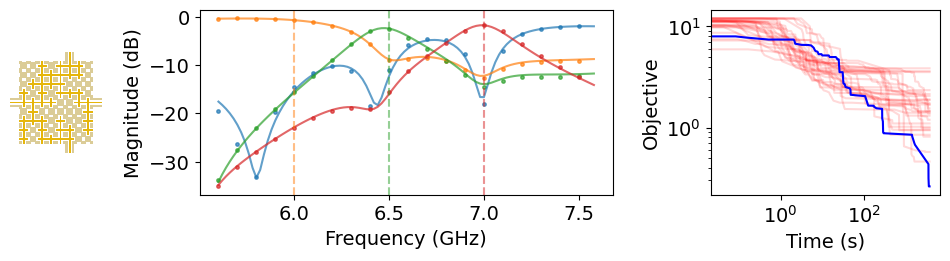

In [ ]:
def buildFor9x8_trimux678_PRE():
    portLocations=[(9,0),(0, 11),(9, 16),(18, 11)]
    setMap=-np.ones([9,8])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    #setMap[6,1]=3
    return portLocations2,setMap

def buildFor9x8_trimux66p57():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.6,7.6,0.02)
        portParams=[np.array([[0,1,0,0],[0,0,0,0],[1,3,1,1],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]),]*len(freqs)
        portLocations2,setMap=buildFor9x8_trimux678_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,lossless=False)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_9x8_trimux66p57_90metal03decayPEC_0602'
useBuildFunc=buildFor9x8_trimux66p57
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/convexPreopt/element4LFree9x8_trimux66p57_90metal03decayPEC_0602.snp'),
             plotFloor=0,
             magVlines=[(6.0,'C1'),(6.5,'C2'),(7.0,'C3')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_9x8_trimux66p57',
             yesPhase=False,
             logy=True)

In [ ]:
arr1=np.array([1.,2,3,4])
arr1[np.array([True,False,True,False])]

array([1., 3.])

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


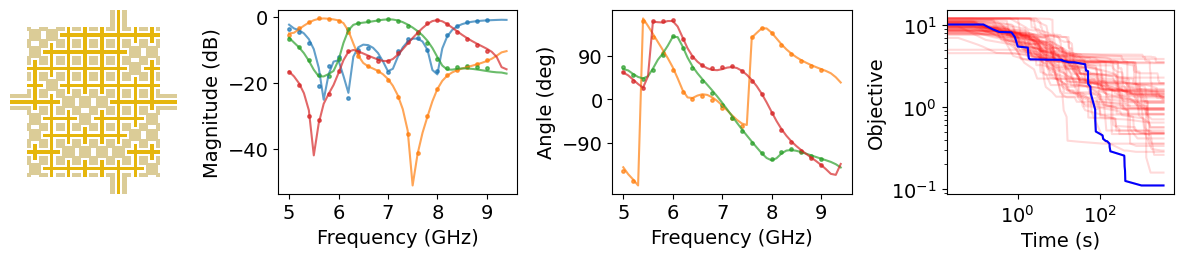

In [ ]:
def buildFor9x8_trimux678_PRE():
    portLocations=[(9,0),(0, 11),(9, 16),(18, 11)]
    setMap=-np.ones([9,8])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    #setMap[6,1]=3
    return portLocations2,setMap

def buildFor9x8_trimux678():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.0,9.5,0.1)
        portParams=[np.array([[0,1,0,0],[0,0,0,0],[1,3,1,1],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]),]*len(freqs)
        portLocations2,setMap=buildFor9x8_trimux678_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,lossless=False)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_9x8_trimux678_90metal03decayPEC_0602'
useBuildFunc=buildFor9x8_trimux678
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree9x8_trimux678_90metal03decayPEC_0602.snp'),
             plotFloor=0,
             magVlines=[],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_9x8_trimux678.png', logy=True,
             xlabels=[5,6,7,8,9],
             size=(12,2.7))

In [ ]:
_=scrub_touchstone_snp('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree9x8_1to6MagA_90metal03decayPEC_0602.snp',7,'/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree9x8_1to6MagA_90metal03decayPEC_0602.snp')

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


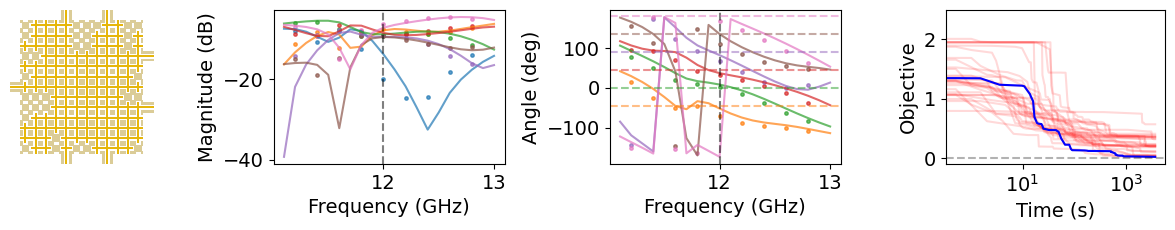

In [ ]:
def buildFor13x12_1to6EquiMagPRSq_PRE():
    portLocations=[(13,0),(0,9),(0,17),(7,24),(17,24),(26,17),(26,9)]
    setMap=-np.ones([13,12])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor13x12_1to6PP12G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(11.1,13.1,0.1)
        portParams=[np.array([[0,1/6*0.95,1/6*0.95,1/6*0.95,1/6*0.95,1/6*0.95,1/6*0.95], #target magnitude of the S-param for port X
                        [0,-45,0,45,90,135,180], #target phase in degrees of the S-param for port X
                        [1,0,0,0,0,0,0], #weight on magnitude objective for port X
                        [0,1,1,1,1,1,1], #weight on the phase objective for port X
                        [0,0,0,0,0,0,0], #Target port for equiphase. portParams[freq][4][i]=j means port i and j will have the same phase.
                        [0,0,0,0,0,0,0], #Weight on eqiphase
                        [0,0,0,0,0,0,0], #Target for equimag
                        [0,0,0,0,0,0,0], #Weight for equimag
                        [0,0,0,0,0,0,0], #Target for ratio phase (delta phase adopts the phase objective)
                        [0,0,0,0,0,0,0], #Weight for ratio phase
                        [0,0,0,0,0,0,0], #Weight on square of S
                        [0,0,0,0,0,0,0], #Weight on inverse square of S
                        ]),]*len(freqs)
        portLocations2,setMap=buildFor13x12_1to6EquiMagPRSq_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output','output','output','output'],portParams=portParams,freq=freqs)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_13x12_1to6PP12G_90metal03decayPEC_0602'
useBuildFunc=buildFor13x12_1to6PP12G
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree13x12_1to6PP12G_90metal03decayPEC_0603.snp'),
             plotFloor=0,
             magVlines=[(12.0,'Black')],
             phaseVlines=[(12.0,'Black')],
             phaseHlines=[(-45,'C1'),(0,'C2'),(45,'C3'),(90,'C4'),(135,'C5'),(180,'C6')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_13x12_1to6PP12G.png')

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


/tmp/ipykernel_2879851/503784596.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


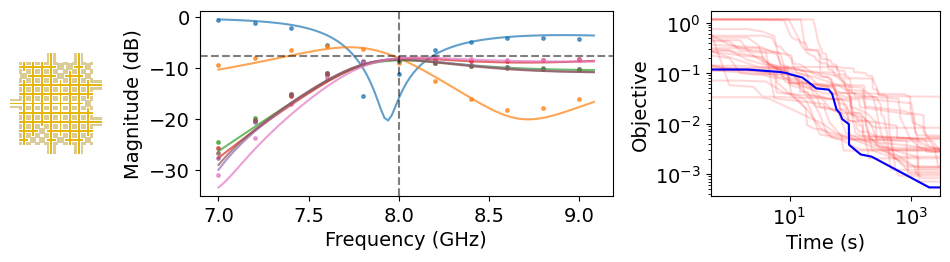

In [ ]:
def buildFor9x8_1to6MagA_PRE():
    portLocations=[(9,0),(0,7),(0,13),(5,16),(13,16),(18,13),(18,7)]
    setMap=-np.ones([9,8])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor9x8_1to6MagA():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(7.0,9.1,0.02)
        portParams=[np.array([[0,1/6*0.96,1/6*0.96,1/6*0.96,1/6*0.96,1/6*0.96,1/6*0.96], #target magnitude of the S-param for port X
                        [0,0,45,90,0,45,90], #target phase in degrees of the S-param for port X
                        [1,1,1,1,1,1,1], #weight on magnitude objective for port X
                        [0,0,0,0,0,0,0], #weight on the phase objective for port X
                        [0,0,0,0,0,0,0], #Target port for equiphase. portParams[freq][4][i]=j means port i and j will have the same phase.
                        [0,0,0,0,0,0,0], #Weight on eqiphase
                        [0,0,0,0,0,0,0],#Target for equimag
                        [0,0,0,0,0,0,0],#Weight for equimag
                        [0,0,0,0,0,0,0], #Target for ratio phase (delta phase adopts the phase objective)
                        [0,0,0,0,0,0,0], #Weight for ratio phase
                        [0,0,0,0,0,0,0], #Weight on square of S
                        [0,0,0,0,0,0,0], #Weight on inverse square of S
                        ]),]*len(freqs)
        portLocations2,setMap=buildFor9x8_1to6MagA_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output','output','output','output'],portParams=portParams,freq=freqs)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_9x8_1to6MagA_90metal03decayPEC_0602'
useBuildFunc=buildFor9x8_1to6MagA
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree9x8_1to6MagA_90metal03decayPEC_0602.snp'),
             plotFloor=0,
             magVlines=[(8.0,'black')],
             magHlines=[(10*np.log10(1/6),'black')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_9x8_1to6MagA.png',
             yesPhase=False,
             xlims=[0.5,3000],
             logy=True)

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


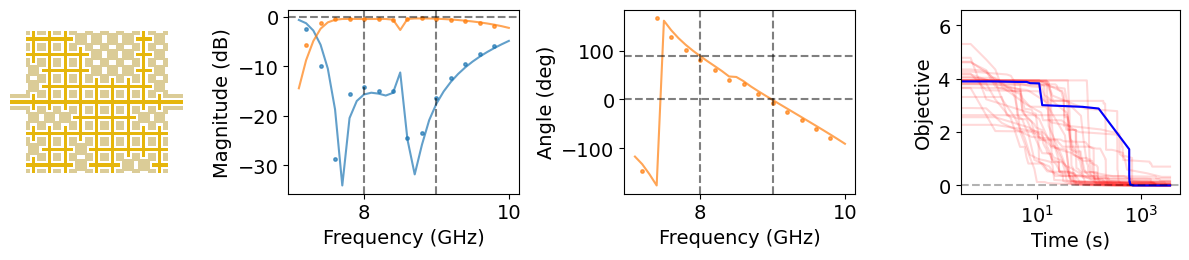

In [ ]:
def buildFor9x9_Phaser1G_PRE():
    portLocations=[(9,0),(9,18)]
    setMap=-np.ones([9,9])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor9x9_Phaser1G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(7.1,10.1,0.1)
        portParams=[np.array([[0,1*0.97],[0,90],[1,0],[0,1],[0,0],[0,0]]),
                    np.array([[0,1*0.97],[0,0],[1,0],[0,1],[0,0],[0,0]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor9x9_Phaser1G_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output'],portParams=portParams,freq=freqs)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_9x9_Phaser1G_90metal03decayPEC_0602'
useBuildFunc=buildFor9x9_Phaser1G
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree9x9_Phaser1G_90metal03decayPEC_0602.snp'),
             plotFloor=0,
             magVlines=[(8.0,'black'),(9.0,'black')],
             magHlines=[(10*np.log10(1),'black')],
             phaseVlines=[(8.0,'black'),(9.0,'black')],
             phaseHlines=[(90,'black'),(0,'black')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_9x9_Phaser1G.png')

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


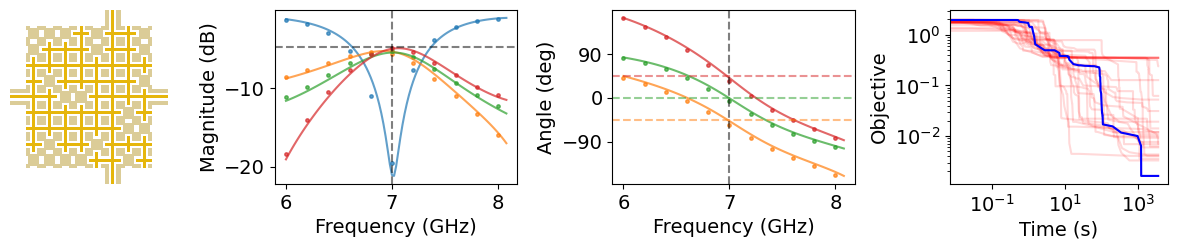

In [ ]:

def buildFor9x8_1to3PP_PRE():
    portLocations=[(9,0),(0, 11),(9, 16),(18, 11)]
    setMap=-np.ones([9,8])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    #setMap[6,1]=3
    return portLocations2,setMap
def buildFor9x8_1to3PP():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(6.0,8.1,0.02)
        portParams=[
                    np.array([[0,1/3*0.95,1/3*0.95,1/3*0.95],[0,-45,0,45],[1,0,0,0],[0,1,1,1],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor9x8_1to3PP_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,lossless=False)
        return mso
    mso=quickMSO()
    return mso
lop='microwave_9x8_1to3PP_90metal03decayPEC_0602'
useBuildFunc=buildFor9x8_1to3PP
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
plotFile(ffn,useBuildFunc,
         addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree9x8_1to3PP_90metal03decayPEC_0602.snp'),
         plotFloor=0,
         magVlines=[(7.0,'black')],
         magHlines=[(10*np.log10(1/3),'black')],
         phaseVlines=[(7.0,'black')],
         phaseHlines=[(-45,'C1'),(0,'C2'),(45,'C3')],
         saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_9x8_1to3PP',
         logy=True,
         size=(12,2.6))

In [ ]:
def buildFor11x10_ndpaImpedance678_PRE():
    portLocations=[(11,0),(17, 20)]
    setMap=-np.ones([11,10])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    setMap[6,1]=3
    return portLocations2,setMap

def buildFor11x10_impedance678Offset():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.2,9.2,0.2)
        portParams=[
                    np.array([[0,1],[0,0],[1,1],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor11x10_ndpaImpedance678_PRE()

        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output'],portParams=portParams,freq=freqs,lossless=False)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_11x10_ndpaImpedance678Offset_90metal03decayPEC_0524'
useBuildFunc=buildFor11x10_impedance678Offset
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree11x10_impedance678Offset_90metal03decayPEC_0524.snp'),
             plotFloor=0,
             magVlines=[(8.0,'black')],
             magHlines=[(10*np.log10(1/6),'black')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_11x10_impedance678Offset.png')

NameError: name 'touchstone2array' is not defined

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


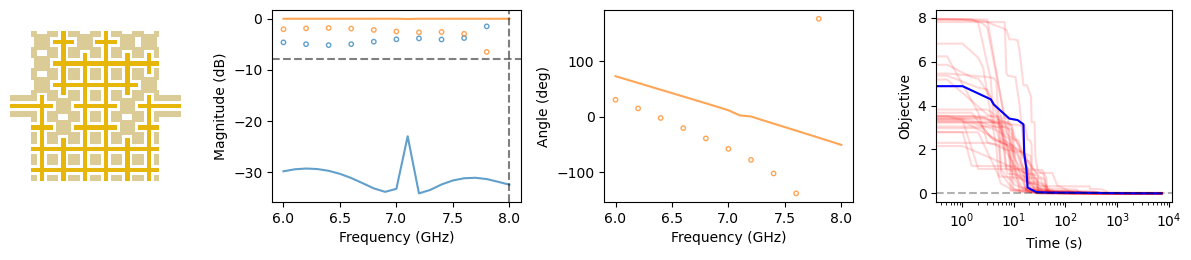

In [ ]:
def rotateS(S):
    """
    Rotate a 4×4 S-matrix by rolling the port labels: 1→2→3→4→1.

    Parameters
    ----------
    S : array-like, shape (4,4)
        Complex S-matrix where S[i,j] is the scattering from port j to port i.

    Returns
    -------
    S_rot : ndarray, shape (4,4)
        The rotated S-matrix.
    """
    S = np.asarray(S)
    if S.shape != (4, 4):
        raise ValueError(f"rotateS requires a 4×4 array, got shape {S.shape}")
    # roll rows down by 1 and columns right by 1
    # element S[i,j] moves to S_rot[i+1 mod 4, j+1 mod 4]
    S_rot = np.roll(S, shift=(1, 1), axis=(0, 1))
    return S_rot

def buildFor7x6_ndpaImpedance678_PRE():
    portLocations=[(7,0),(7, 12),]
    setMap=-np.ones([7,6])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    setMap[4,1]=3
    return portLocations2,setMap
def buildFor7x6_ndpaImpedance678():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(6.0,8.1,0.1)
        portParams=[
                    np.array([[0,1],[0,0],[1,1],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor7x6_ndpaImpedance678_PRE()

        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output'],portParams=portParams,freq=freqs,lossless=False,whichImpedance=1)
        for kk in mso.sMats[3].keys():
            mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            #mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            continue
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_7x6_ndpaImpedance678_90metal03decayPEC_0612'
useBuildFunc=buildFor7x6_ndpaImpedance678
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree7x6_ndpaImpedance678_90metal03decayPEC_0612.snp'),
             plotFloor=0,
             magVlines=[(8.0,'black')],
             magHlines=[(10*np.log10(1/6),'black')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_7x6_impedance678.png')

[-0.56029266+0.20266373j  0.40505522-0.06431884j  0.5329338 -0.16996405j
  0.3896177 -0.1097946j ]


/tmp/ipykernel_2879851/503784596.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


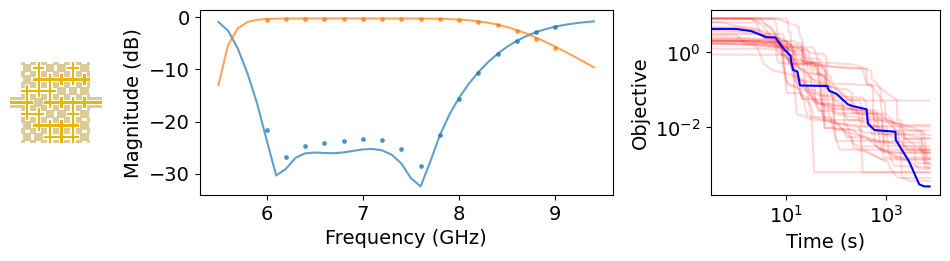

In [ ]:
def buildFor7x6_ndpaImpedance678_PRE():
    portLocations=[(7,0),(7, 12),]
    setMap=-np.ones([7,6])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    setMap[4,1]=3
    return portLocations2,setMap
def buildFor7x6_ndpaImpedance678():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.5,9.5,0.1)
        portParams=[
                    np.array([[0,1],[0,0],[1,1],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor7x6_ndpaImpedance678_PRE()

        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output'],portParams=portParams,freq=freqs,lossless=False,whichImpedance=2)
        for kk in mso.sMats[3].keys():
            #mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            #mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            #mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            continue
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_7x6_ndpaImpedance25In678_90metal03decayPEC_0612'
useBuildFunc=buildFor7x6_ndpaImpedance678
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree7x6_ndpaImpedance25In678_90metal03decayPEC_0612.snp'),
             plotFloor=0,
             magVlines=[],
             magHlines=[],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_7x6_impedance678B.png',
             yesPhase=False,
             logy=True)

#### Cares

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


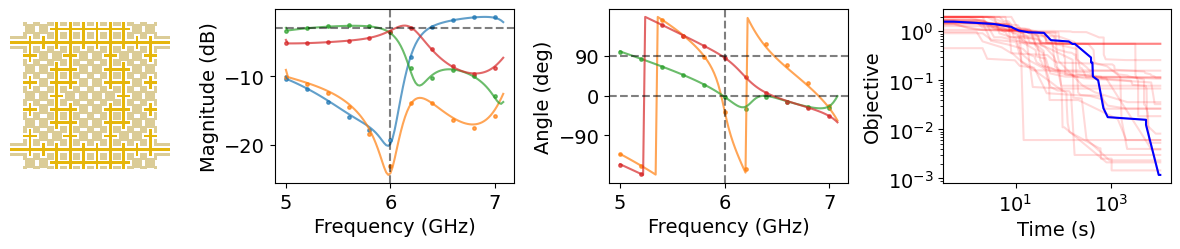

In [ ]:
def buildFor11x10_90degHybrid_PRE():
    portLocations=[(3,0),(19,0),(3,20),(19,20)]
    setMap=-np.ones([11,10])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap
def buildFor11x10_90degHybrid():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.0,7.1,0.02)
        portParams=[
                    np.array([[0,0,0.5*0.97,0.5*0.97],[0,0,45,135],[1,1,0,0],[0,0,1,1],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor11x10_90degHybrid_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,lossless=False)
        mso.useSparse=True
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_11x10_90degHybrid6G_90metal03decayPEC_0617'
useBuildFunc=buildFor11x10_90degHybrid
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree11x10_90degHybrid6G_90metal03decayPEC_0617.snp'),
             plotFloor=0,
             magVlines=[(6,'black')],
             magHlines=[(10*np.log10(1/2),'black')],
             phaseVlines=[(6,'black')],
             phaseHlines=[(90,'black'),(0,'black')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_7x6_90degHybrid6G.png',
             logy=True,
         size=(12,2.6))

5.000000000000000 -0.336956615036 0.3255186365931 0.3053556977558 0.3725092196476 -0.372537638012 0.3624395273373 -0.311592986279 -0.377517326041
0.3053556977557 0.3725092196476 -0.336959658509 0.3255084512021 -0.311590976233 -0.377524134313 -0.372544788039 0.3624321339350
[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


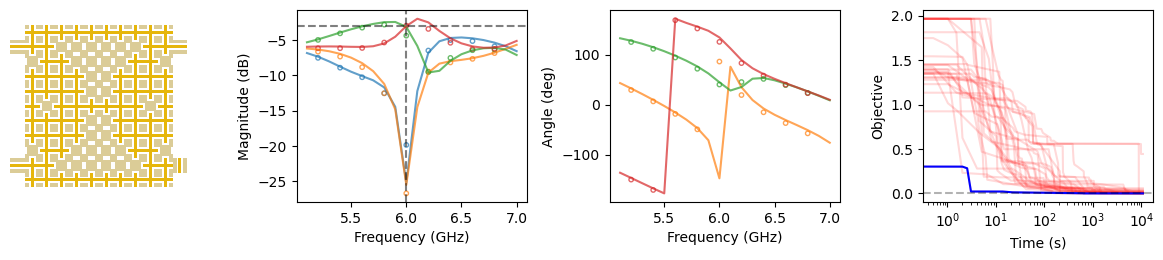

In [ ]:
def buildFor11x10_90degHybrid_PRE():
    portLocations=[(3,0),(19,0),(3,20),(19,20)]
    setMap=-np.ones([11,10])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap
def buildFor11x10_90degHybrid():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.1,7.1,0.1)
        portParams=[
                    np.array([[0,0,0.5*0.97,0.5*0.97],[0,0,45,135],[1,1,0,0],[0,0,1,1],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor11x10_90degHybrid_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,lossless=False)
        mso.useSparse=True
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_11x10_90degHybrid6GB_90metal03decayPEC_0617'
useBuildFunc=buildFor11x10_90degHybrid
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree11x10_90degHybrid6GB_90metal03decayPEC_0617.snp'),
             plotFloor=0,
             magVlines=[(6,'black')],
             magHlines=[(10*np.log10(1/2),'black')],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_7x6_90degHybrid6GB.png')

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


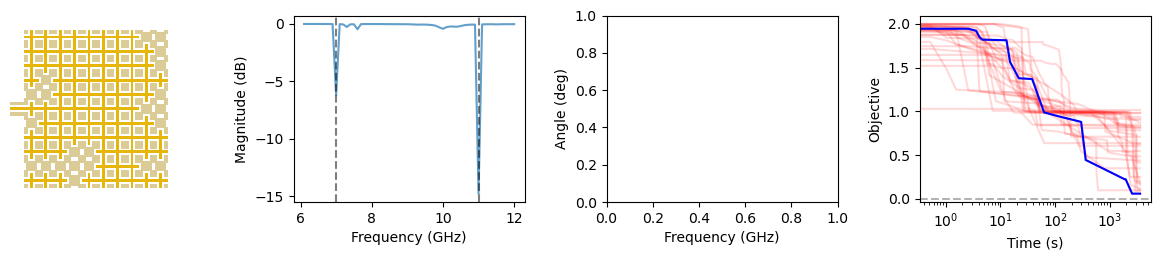

In [ ]:
def buildFor11x10_antenna7911_PRE():
    portLocations=[(11,0)]
    setMap=-np.ones([11,10])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap
def buildFor11x10_antenna7911():
    def quickMSO():
        mso=micropatchSimObject()
        freqs=np.arange(6.1,12.1,0.1)
        portParams=[
                    np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],]),
                    np.array([[1],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],]),
                    np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor11x10_antenna7911_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input'],portParams=portParams,freq=freqs,lossless=False)
        mso.useSparse=True
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
lop='microwave_11x10_antenna7911_90metal03decayPEC_0617'
useBuildFunc=buildFor11x10_antenna7911
ffn='/home/groundnet/Desktop/Nate/convexPreopt/microwaveTradResults/'+lop+'_RANDtrad.txt'
mso=plotFile(ffn,useBuildFunc,
             addExperimental=None,#touchstone2array('/home/groundnet/Desktop/Nate/microwaveTrad/element4LFree7x6_ndpaImpedance25In678_90metal03decayPEC_0612.snp'),
             plotFloor=0,
             magVlines=[(7,'black'),(11,'black')],
             magHlines=[],
             saveAs='/home/groundnet/Desktop/Nate/microwaveTrad/mw_11x10_antenna7911.png')

In [ ]:
10*0.0015

0.015

In [ ]:
(2e8)/(11*1e9)

0.01818181818181818

### Timing

In [ ]:
ex1x1=np.array([[1,],])
ex1x2=np.array([[1,1],])
ex3x2=np.array([[0,1],
                [1,1],
                [0,1]])
ex3x3=np.array([[0,1,0],
                [1,1,1],
                [0,1,0]])
ex5x4=np.array([[0,0,1,0],
                [0,1,1,0],
                [1,1,1,1],
                [0,1,1,0],
                [0,0,1,0]])
ex5x5=np.array([[0,0,1,0,0],
                [0,1,1,0,0],
                [1,1,1,1,1],
                [0,1,1,0,0],
                [0,0,1,0,0]])
ex7x6=np.array([[0,0,0,1,0,0],
                [0,0,1,1,0,0],
                [0,1,1,0,0,0],
                [1,1,1,1,1,1],
                [0,1,1,0,0,0],
                [0,0,1,1,0,0],
                [0,0,0,1,0,0],])
ex7x7=np.array([[0,0,0,1,0,0,0],
                [0,0,1,1,0,0,0],
                [0,1,1,0,0,0,0],
                [1,1,1,1,1,1,1],
                [0,1,1,0,0,0,0],
                [0,0,1,1,0,0,0],
                [0,0,0,1,0,0,0],])
ex9x8=np.array([[0,0,0,0,1,0,0,0],
                [0,0,0,1,1,0,0,0],
                [0,0,1,1,0,0,0,0],
                [0,1,1,0,0,0,0,0],
                [1,1,1,1,1,1,1,1],
                [0,1,1,0,0,0,0,0],
                [0,0,1,1,0,0,0,0],
                [0,0,0,1,1,0,0,0],
                [0,0,0,0,1,0,0,0],])
ex9x9=np.array([[0,0,0,0,1,0,0,0,0],
                [0,0,0,1,1,0,0,0,0],
                [0,0,1,1,0,0,0,0,0],
                [0,1,1,0,0,0,0,0,0],
                [1,1,1,1,1,1,1,1,1],
                [0,1,1,0,0,0,0,0,0],
                [0,0,1,1,0,0,0,0,0],
                [0,0,0,1,1,0,0,0,0],
                [0,0,0,0,1,0,0,0,0],])
ex11x10=np.array([[0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,1,0,0,0,0],
                  [0,0,0,1,1,0,0,0,0,0],
                  [0,0,1,1,0,0,0,0,0,0],
                  [0,1,1,0,0,0,0,0,0,0],
                  [1,1,1,1,1,1,1,1,1,1],
                  [0,1,1,0,0,0,0,0,0,0],
                  [0,0,1,1,0,0,0,0,0,0],
                  [0,0,0,1,1,0,0,0,0,0],
                  [0,0,0,0,1,1,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],])
def runTimingEx(timingEx):
    teBase=-np.ones_like(timingEx)
    teBase=np.pad(teBase,((1,1),(1,1)),'constant',constant_values=0)
    te=np.pad(timingEx,((1,1),(1,1)),'constant',constant_values=0)
    txShape=te.shape
    lls=[(0,txShape[1]//2),(txShape[0]-1,txShape[1]//2),(txShape[0]//2,txShape[1]-1),(txShape[0]//2,0)]
    for ll in lls:
        teBase[ll[0],ll[1]]=2
    portLocations2=[(0,txShape[1]+(1-txShape[1]%2)),(txShape[0]*2,txShape[1]+(1-txShape[1]%2)),(txShape[0]+(1-txShape[0]%2),txShape[1]*2),(txShape[0]+(1-txShape[0]%2),0)]
    mso=micropatchSimObject() #Instantiate the mso object
    freqs=np.arange(5.1,15.1,0.1)
    portParams=[np.array([[0,1,0,0],[0,0,0,0],[1,3,1,1],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]),]*len(freqs)

    mso=buildMSOCPW(mso,teBase,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,lossless=False)
    t0=datetime.datetime.now()
    mso.useSparse=False
    ss=mso.getSO(te,useA0=False,sdpObj=False)
    dt=datetime.datetime.now()-t0
    avgUtil=np.mean([t[1] for t in mso.timings[0]])
    avgMem=np.mean([t[2] for t in mso.timings[0]])/ 1024**3
    totTime=mso.timings[0][-1][0]-mso.timings[0][0][0]
    fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4,4))
    ax=draw_pcb(ax,mso.setMap)
    #ax.set_axis('off')
    plt.show()
    print('Total time including matrix build and I/O: '+str(dt.total_seconds()))
    print('Time spent on solver alone: '+str(np.sum(mso.ts)))
    print('Time per frequency: '+str(np.mean(mso.ts)))
    print('Average CPU util from parent and children during solve: '+str(avgUtil)+'%')
    print('Average memory use by parent and children during solve: '+str(avgMem)+' GB')
    return mso

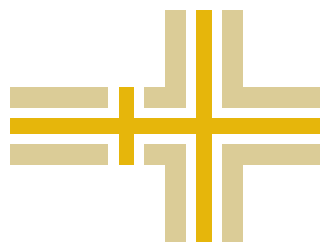

Total time including matrix build and I/O: 0.549939
Time spent on solver alone: 0.03773094480857253
Time per frequency: 0.0003773094480857253
Average CPU util from parent and children during solve: 0.0%
Average memory use by parent and children during solve: 0.3596153259277344 GB


In [ ]:
mso=runTimingEx(ex1x2)
aa=sps.csr_array(mso.A)

In [ ]:
smmMemory=np.array([95376,95460,96232,96632,96696,96760,97452,97020,98364,98604,98796])/1024-94120/1024
smmTime=np.array([0.0002680744091048837,0.00039454962592571974,0.0005625445395708084,0.0007191079622134567,0.001175570939667523,0.0012729424377903341,0.0017949611460790038,0.001956281769089401,0.0024373985920101405,0.002889906014315784,0.00357913825660944])
sonnetTimingsFullCores=[5,5,3,5,8,12,36,53,129,179,417]
sonnetTimingsOneCore=[26,37,24,37,50,74,234,347,14*60+41,20*60+35,48*60+55]
sonnetRAMFullCores=[342,342,145,209,523,750,1773,2372,4842,6119,11073]
sonnetRAMOneCore=[284,338,214,282,600,833,1869,2471,4969,6253,11264]
comsolTimingsFullCores=[21,26,34,48,77]
comsolRAMFullCores=[6.78*1032,8.01*1032,10.1*1032,13.07*1032,20.29*1032]
comsolSizes=[2,3*3,5*5,7*7,11*10]
sizes=[1,2,6,3*3,5*4,5*5,7*6,7*7,9*8,9*9,11*10]

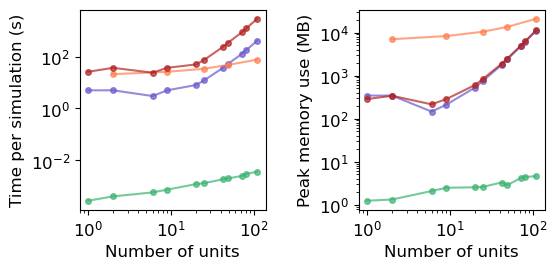

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(6,2.6),gridspec_kw={'wspace':0.5})
ax[0].plot(sizes,smmTime,'o-',label='SMM (1 Core)',color='mediumseagreen',alpha=0.7,markersize=4)
ax[0].plot(sizes,sonnetTimingsFullCores,'o-',label='BEM (24 Cores)',color='slateblue',alpha=0.7,markersize=4)
ax[0].plot(comsolSizes,comsolTimingsFullCores,'o-',label='FEM (24 Core)',color='coral',alpha=0.7,markersize=4)
ax[0].plot(sizes,sonnetTimingsOneCore,'o-',label='BEM (1 Core)',color='firebrick',alpha=0.7,markersize=4)
fontsize=12
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel('Time per simulation (s)',fontsize=fontsize)
ax[0].set_xlabel('Number of units',fontsize=fontsize)

#ax[0].legend(loc='upper left',fontsize=8)
ax[1].plot(sizes,smmMemory,'o-',label='SMM',color='mediumseagreen',alpha=0.7,markersize=4)
ax[1].plot(sizes,sonnetRAMFullCores,'o-',label='BEM',color='slateblue',alpha=0.7,markersize=4)
ax[1].plot(comsolSizes,comsolRAMFullCores,'o-',label='FEM',color='coral',alpha=0.7,markersize=4)
ax[1].plot(sizes,sonnetRAMOneCore,'o-',label='FEM',color='firebrick',alpha=0.7,markersize=4)
ax[1].set_ylabel('Peak memory use (MB)',fontsize=fontsize)
ax[1].set_xlabel('Number of units',fontsize=fontsize)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
for axc in ax:
    axc.tick_params(axis='both', which='major', labelsize=fontsize)
#ax[1].legend(loc='upper left',fontsize=8)
#fig.tight_layout()
plt.savefig('/home/groundnet/Desktop/Nate/microwaveTrad/timing.png',dpi=300,bbox_inches='tight')
plt.show()

### Single Units

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


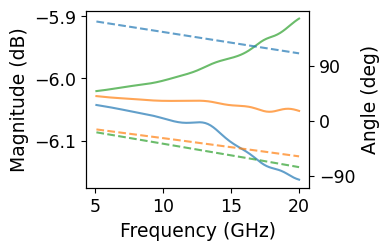

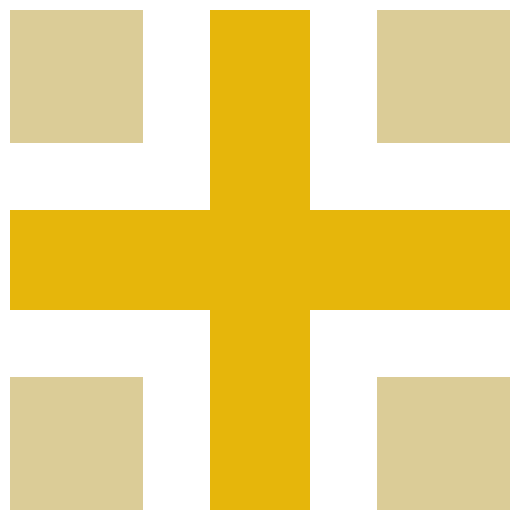

In [ ]:
def buildFor9x9_Phaser1G_PRE():
    portLocations=[(1,0),(0,1),(1,2),(2,1)]
    setMap=-np.ones([1,1])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor9x9_Phaser1G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.1,20.1,0.1)
        portParams=[np.array([[0,1*0.97,1*0.97,1*0.97],[0,90,1*0.97,1*0.97],[1,0,1*0.97,1*0.97],[0,1,1*0.97,1*0.97],[0,0,1*0.97,1*0.97],[0,0,1*0.97,1*0.97]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor9x9_Phaser1G_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4.0,2.6))
useArr=np.array([[0,2,0],[2,1,2],[0,2,0]])
mso= buildFor9x9_Phaser1G()

ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)
fontsize=13.5
smat=np.zeros((len(mso.portTypes),len(sp)),dtype=np.complex64)
freqs=[]
for frq,ss in enumerate(sp):
    for pp,v in enumerate(ss):
        smat[pp,frq]=deepcopy(v)
    freqs.append(mso.ufreqs[frq])

for pp,sr in enumerate(smat[:3]):
    ax.plot(freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)

ax.set_xlabel('Frequency (GHz)',fontsize=fontsize)
ax.set_ylabel('Magnitude (dB)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
ax2=ax.twinx()
for pp,sr in enumerate(smat[:3]):
    ax2.plot(freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp),linestyle='--')
ax2.set_yticks([-90,0,90])
ax2.set_ylim(-110,180)
#ax2.set_xlim(5.1,9.5)
ax2.tick_params(axis='both', which='major', labelsize=fontsize-1)
ax2.set_xlabel('Frequency (GHz)',fontsize=fontsize)
ax2.set_ylabel('Angle (deg)',fontsize=fontsize)
fig.tight_layout()
plt.savefig('/home/groundnet/Desktop/Nate/microwaveTrad/crossPlot.png',dpi=300)
plt.show()
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6.5,6.5))
ax=draw_pcb(ax,np.array([[1]]))
#ax.set_axis('off')
plt.show()

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]


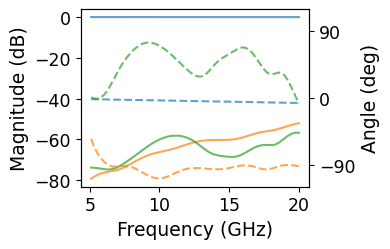

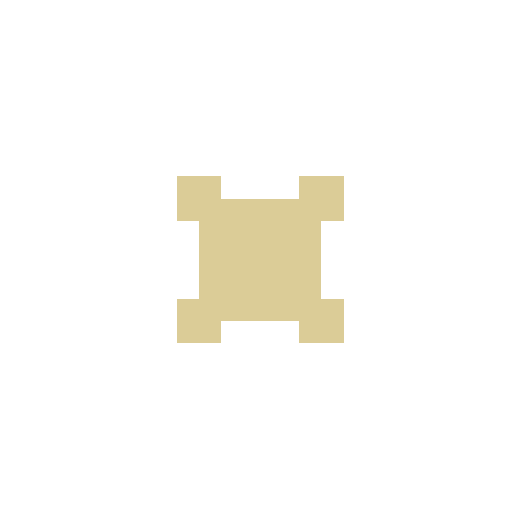

In [ ]:
def buildFor9x9_Phaser1G_PRE():
    portLocations=[(1,0),(0,1),(1,2),(2,1)]
    setMap=-np.ones([1,1])
    portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor9x9_Phaser1G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(5.1,20.1,0.1)
        portParams=[np.array([[0,1*0.97,1*0.97,1*0.97],[0,90,1*0.97,1*0.97],[1,0,1*0.97,1*0.97],[0,1,1*0.97,1*0.97],[0,0,1*0.97,1*0.97],[0,0,1*0.97,1*0.97]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor9x9_Phaser1G_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(4.0,2.6))
useArr=np.array([[0,2,0],[2,0,2],[0,2,0]])
mso= buildFor9x9_Phaser1G()

ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)

smat=np.zeros((len(mso.portTypes),len(sp)),dtype=np.complex64)
freqs=[]
for frq,ss in enumerate(sp):
    for pp,v in enumerate(ss):
        smat[pp,frq]=deepcopy(v)
    freqs.append(mso.ufreqs[frq])

for pp,sr in enumerate(smat[:3]):
    ax.plot(freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)

ax.set_xlabel('Frequency (GHz)',fontsize=fontsize)
ax.set_ylabel('Magnitude (dB)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
ax2=ax.twinx()
for pp,sr in enumerate(smat[:3]):
    ax2.plot(freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp),linestyle='--')
ax2.set_yticks([-90,0,90])
ax2.set_ylim(-120,120)
ax2.tick_params(axis='both', which='major', labelsize=fontsize-1)
ax2.set_xlabel('Frequency (GHz)',fontsize=fontsize)
ax2.set_ylabel('Angle (deg)',fontsize=fontsize)
fig.tight_layout()
plt.savefig('/home/groundnet/Desktop/Nate/microwaveTrad/freePlot.png',dpi=300)
plt.show()
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6.5,6.5))
ax=draw_pcb(ax,np.array([[0,0,0],[0,0,0],[0,0,0]]))
#ax.set_axis('off')
plt.show()

### Impedance testing

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]
5.000000000000000 -0.645495704664 0.2720694899296 0.3256414428810 0.0118077717452 0.5170800056387 -0.203447646441 0.3044148322418 -0.040388906461
0.3256414428810 0.0118077717452 -0.624040301175 0.2979616358167 0.4995169266172 -0.244718352700 0.3256409828001 0.0118076036755


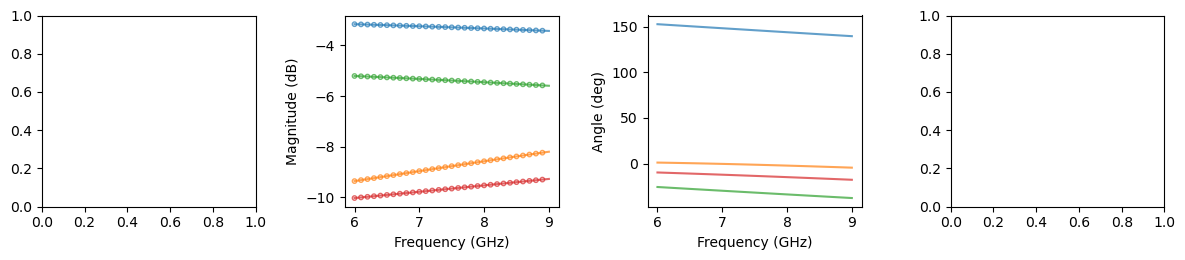

In [ ]:
def buildFor9x9_Phaser1G_PRE():
    portLocations2=[(1,0),(0,1),(1,2),(2,1)]
    setMap=-np.ones([1,1])
    #portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor9x9_Phaser1G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(6.0,9.1,0.1)
        portParams=[np.array([[0,1*0.97,1*0.97,1*0.97],[0,90,1*0.97,1*0.97],[1,0,1*0.97,1*0.97],[0,1,1*0.97,1*0.97],[0,0,1*0.97,1*0.97],[0,0,1*0.97,1*0.97]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor9x9_Phaser1G_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output'],portParams=portParams,freq=freqs,whichImpedance=1)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    for kk in mso.sMats[3].keys():
            mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
            mso.sMats[3][kk]=rotateS(mso.sMats[3][kk])
    return mso
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(12,2.7))
useArr=np.array([[3]])
mso= buildFor9x9_Phaser1G()

ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)

smat=np.zeros((len(mso.portTypes),len(sp)),dtype=np.complex64)
freqs=[]
for frq,ss in enumerate(sp):
    for pp,v in enumerate(ss):
        smat[pp,frq]=deepcopy(v)
    freqs.append(mso.ufreqs[frq])

addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_12p5In_impedanceOrientation.snp')
for pp,sr in enumerate(smat):
    ax[1].plot(freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)
    xs=np.array(list(addExperimental.keys()))
    ys=np.array([addExperimental[ff][0,pp] for ff in xs])
    minSMMFreq=min(freqs)
    maxSMMFreq=max(freqs)
    indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
    xs=xs[indArr]
    ys=ys[indArr]
    ax[1].scatter(xs,20*np.log10(np.abs(ys)),alpha=0.7,marker='o', facecolors='none',edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=10)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Magnitude (dB)')

for pp,sr in enumerate(smat):
    ax[2].plot(freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp))
ax[2].set_xlabel('Frequency (GHz)')
ax[2].set_ylabel('Angle (deg)')
fig.tight_layout()
plt.show()

[-0.6454957 +0.27206948j  0.32564145+0.01180777j  0.51708   -0.20344764j
  0.30441484-0.04038891j]
6.000000000000000 0.5496898097156 0.2891932037240 0.2332430705470 -0.387403469656 0.1951690699870 -0.408831703976 0.2332426593487 -0.387403092182
0.2332430705472 -0.387403469657 -0.457250483742 0.3343203285361 0.5015289029490 0.0061651156478 0.4706853656805 -0.038491693660


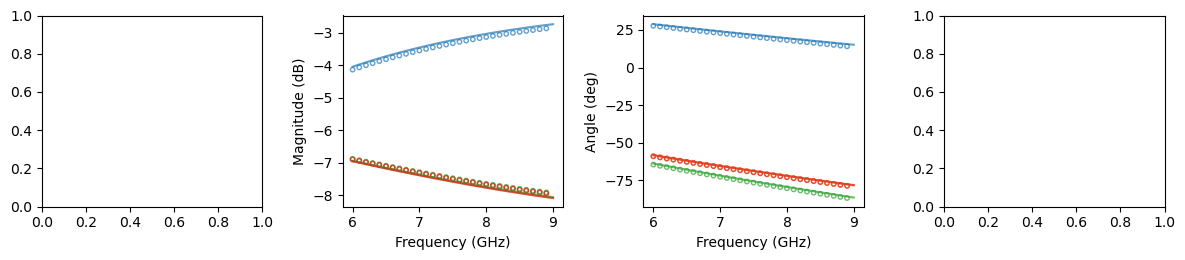

In [ ]:
def buildFor9x9_Phaser1G_PRE():
    portLocations2=[(1,0),(0,3),(1,4),(2,3)]
    setMap=-np.ones([1,2])
    #portLocations2,setMap=processSetMap(portLocations,setMap)
    return portLocations2,setMap

def buildFor9x9_Phaser1G():
    def quickMSO():
        mso=micropatchSimObject() #Instantiate the mso object
        freqs=np.arange(6.0,9.1,0.1)
        portParams=[np.array([[0,1*0.97,0,0,],[0,90,0,0,],[1,0,0,0,],[0,1,0,0,],[0,0,0,0,],[0,0,0,0,]]),
                        ]*len(freqs)
        portLocations2,setMap=buildFor9x9_Phaser1G_PRE()
        mso=buildMSOCPW(mso,setMap,portLocations2,symmetryAxis=None,portTypes=['input','output','output','output',],portParams=portParams,freq=freqs,whichImpedance=1)
        return mso
    mso=quickMSO()
    mso.useSparse=True
    return mso
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(12,2.7))
useArr=np.array([[3,1]])
mso= buildFor9x9_Phaser1G()

ov,sp=mso.getSO(useArr,useA0=False,sdpObj=False)

smat=np.zeros((len(mso.portTypes),len(sp)),dtype=np.complex64)
freqs=[]
for frq,ss in enumerate(sp):
    for pp,v in enumerate(ss):
        smat[pp,frq]=deepcopy(v)
    freqs.append(mso.ufreqs[frq])

addExperimental=touchstone2array('/home/groundnet/Desktop/Nate/convexPreopt/element4LFreeCPWPEC_impedanceOrientation.snp')
for pp,sr in enumerate(smat):
    ax[1].plot(freqs,20*np.log10(np.abs(sr)),label='S1'+str(pp+1)+', SMM',alpha=0.7)
    xs=np.array(list(addExperimental.keys()))
    ys=np.array([addExperimental[ff][0,pp] for ff in xs])
    minSMMFreq=min(freqs)
    maxSMMFreq=max(freqs)
    indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
    xs=xs[indArr]
    ys=ys[indArr]
    ax[1].scatter(xs,20*np.log10(np.abs(ys)),alpha=0.7,marker='o', facecolors='none',edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=10)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('Magnitude (dB)')

for pp,sr in enumerate(smat):
    ax[2].plot(freqs,np.angle(sr,deg=True),label='S1'+str(pp+1)+', SMM',alpha=0.7,color='C'+str(pp))
    xs=np.array(list(addExperimental.keys()))
    ys=np.array([addExperimental[ff][0,pp] for ff in xs])
    minSMMFreq=min(freqs)
    maxSMMFreq=max(freqs)
    indArr=((xs<=maxSMMFreq) * (xs>=minSMMFreq)).astype(bool)
    xs=xs[indArr]
    ys=ys[indArr]
    ax[2].scatter(xs,np.angle(ys,deg=True),alpha=0.7,marker='o', facecolors='none',edgecolors='C'+str(pp),label='S1'+str(pp+1)+', BEM',s=10)
ax[2].set_xlabel('Frequency (GHz)')
ax[2].set_ylabel('Angle (deg)')
fig.tight_layout()
plt.show()

In [ ]:
mso.sMats[mso.setMap[1, 1]][chosenFreq]

KeyError: 6.0

In [ ]:
S=mso.sMats[3][6.0]


In [ ]:
S

array([[ 0.21801683+0.21612635j,  0.49507153-0.237632j  ,
         0.49507082-0.2376321j ,  0.47058925-0.28478226j],
       [ 0.49507153-0.237632j  , -0.6172688 +0.3189796j ,
         0.3108753 -0.053312j  ,  0.34056792+0.00661191j],
       [ 0.49507082-0.2376321j ,  0.3108753 -0.053312j  ,
        -0.6172693 +0.3189809j ,  0.34056756+0.00661166j],
       [ 0.47058925-0.28478226j,  0.34056792+0.00661191j,
         0.34056756+0.00661166j, -0.5879709 +0.3459542j ]],
      dtype=complex64)

In [ ]:
A=np.array([[S[0,0]+1,S[0,1],  S[0,3],  0],
            [S[1,0],  S[1,1]+1,S[1,3],  0],
            [S[2,0],  S[2,1],  S[2,3], -1],
            [S[3,0],  S[3,1],  S[3,3]+1,0]])
b=-S[:,2]
a,b,c,d=np.linalg.solve(A,b)
inV=np.array([a,b,1,c])
print(inV)
print(d)
print(S@inV)

[-0.39407287+0.09157739j -0.19534983+0.04585938j  1.        +0.j
 -0.39407287+0.09157739j]
(-0.8970336285112933+0.44172559127171174j)
[ 0.39407287-0.09157739j  0.19534983-0.04585938j -0.89703363+0.44172559j
  0.39407287-0.09157739j]


In [ ]:
mso.e[6.0]

array([ 0.        +0.j        ,  0.49507082-0.2376321j ,
        1.        +0.j        , -0.61726928+0.3189809j ,
        0.3108753 -0.053312j  ,  0.        +0.j        ,
        0.34056756+0.00661166j,  0.        +0.j        ])

In [ ]:
S@np.array([0,0,1,0])

array([ 0.49507082-0.2376321j ,  0.3108753 -0.053312j  ,
       -0.61726928+0.3189809j ,  0.34056756+0.00661166j])

###Boundary Search

In [ ]:
# Generate 16 random numbers summing to 1
data = np.random.dirichlet(np.ones(16)).reshape((4, 4))


In [ ]:
frozenData=np.array([[0.02128012, 0.14743374, 0.02487079, 0.00162964],
 [0.12190917, 0.05148556, 0.0356908,  0.11925697],
 [0.03757869, 0.02703421, 0.03276192, 0.13538907],
 [0.05431212, 0.04680907, 0.00694536, 0.13561277]])

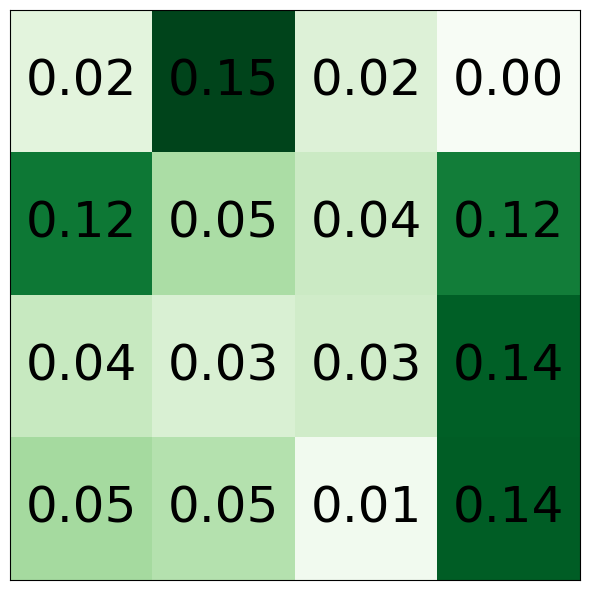

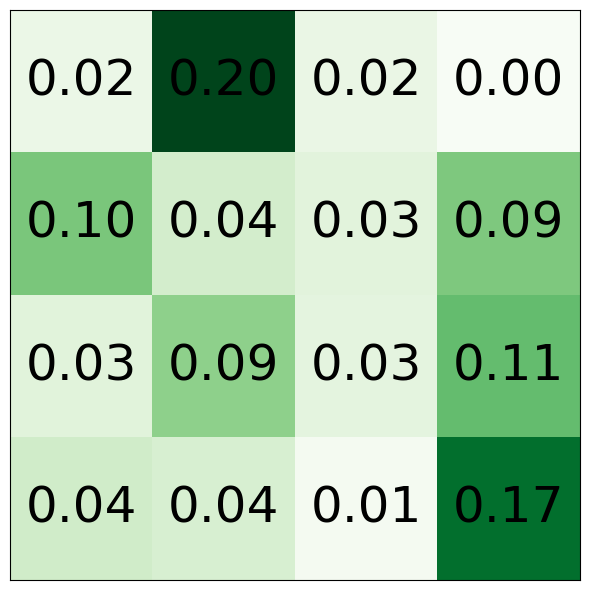

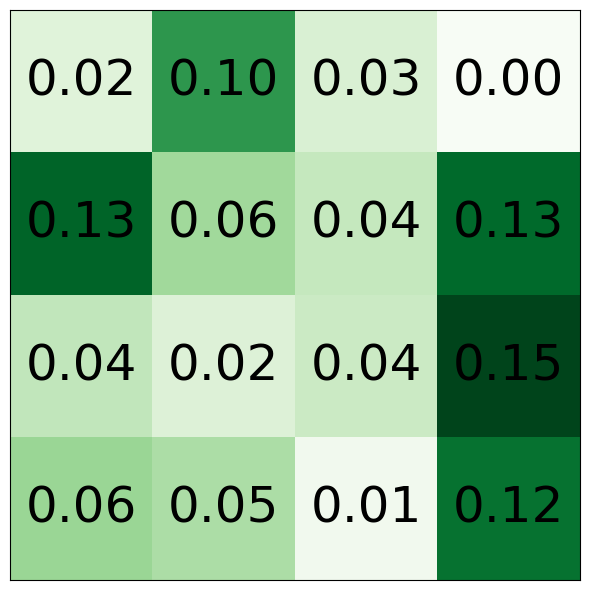

In [ ]:

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frozenData, cmap='Greens')

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Annotate each cell with the number (3 decimal places)
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{frozenData[i, j]:.2f}", ha='center', va='center',fontsize=36)

# Ensure the plot is square
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

frozenDatPlus=frozenData*np.array([[1,1.7,1,1],[1,1,1,1],[1,4.0,1,1],[1,1,1,1.6]])
frozenDatPlus=frozenDatPlus/np.sum(frozenDatPlus)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frozenDatPlus, cmap='Greens')

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Annotate each cell with the number (3 decimal places)
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{frozenDatPlus[i, j]:.2f}", ha='center', va='center',fontsize=36)

# Ensure the plot is square
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

frozenDatMinus=frozenData*np.array([[1,0.65,1,1],[1,1,1,1],[1,0.85,1,1],[1,1,1,0.85]])
frozenDatMinus=frozenDatMinus/np.sum(frozenDatMinus)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(frozenDatMinus, cmap='Greens')

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Annotate each cell with the number (3 decimal places)
for i in range(4):
    for j in range(4):
        ax.text(j, i, f"{frozenDatMinus[i, j]:.2f}", ha='center', va='center',fontsize=36)

# Ensure the plot is square
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

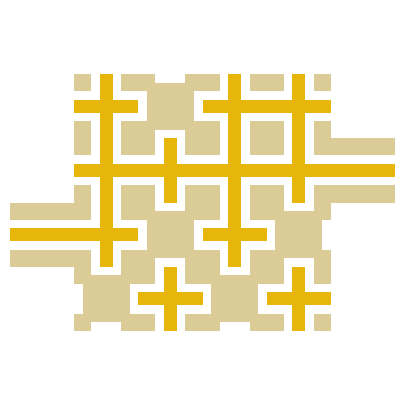

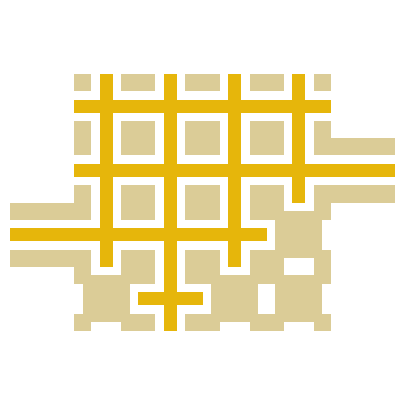

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(5,5))
ax=draw_pcb(ax,np.array([[0,0,0,0,0,0],
                         [0,1,0,1,1,0],
                         [0,1,1,1,1,2],
                         [2,1,0,1,0,0],
                         [0,0,1,0,1,0],
                         [0,0,0,0,0,0]]))
#ax.set_axis('off')
plt.show()
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(5,5))
ax=draw_pcb(ax,np.array([[0,0,0,0,0,0],
                         [0,1,1,1,1,0],
                         [0,1,1,1,1,2],
                         [2,1,1,1,0,0],
                         [0,0,1,0,0,0],
                         [0,0,0,0,0,0]]))
#ax.set_axis('off')
plt.show()